
# **Artificial Intelligence: First Project**

### Author: Sofía Vega

<div class="alert alert-block alert-info">


</div>

## **1. Linear Classification: Test Dataset**

In this section, we will implement and compare two classifiers for a binary classification problem: a standard logistic regression model trained using Scikit-learn and a custom classifier based on the mean vector of class 1. Then, we will visualize their decision boundaries and evaluate both using various classification metrics

---


### **1.0 Necessary Libraries**

In [100]:
# Import necessary libraries
from IPython.display import display, HTML
display(HTML("<style>.rendered_html { text-align: justify; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, r2_score
from matplotlib.colors import ListedColormap

---

### **1.2 Function Definitions**

#### **1.2.1 Data Generation**

<div style="text-align: justify">
The `generate_data` function creates a synthetic dataset for the binary classification task. It produces two groups of data points in 2D space, each sampled from a multivariate normal distribution with a specified mean. This setup allows us to simulate two distinct classes—class 0 and class 1—that can be used to train and evaluate classification models. By adjusting the input means, we can control how separable the classes are, which in turn affects the complexity of the classification problem.
</div>




In [4]:
def generate_data(n_samples, seed, mean0, mean1):
    """
    Generate synthetic 2D Gaussian data for binary classification.
    
    Parameters:
    - n_samples: int, number of samples per class
    - seed: int, random seed for reproducibility
    - mean0: np.array, mean of class 0
    - mean1: np.array, mean of class 1

    Returns:
    - X: np.ndarray of shape (2*n_samples, 2), feature matrix
    - y: np.ndarray of shape (2*n_samples,), label vector (0 or 1)
    """
    np.random.seed(seed)
    cov = np.eye(2)
    X0 = np.random.multivariate_normal(mean0, cov, n_samples)
    X1 = np.random.multivariate_normal(mean1, cov, n_samples)
    X = np.vstack((X0, X1))
    y = np.hstack((np.zeros(n_samples), np.ones(n_samples)))
    return X, y


#### **1.2.2 Data Splitting**

The `split_data` function divides the full dataset into a training set and a test set using scikit-learn’s `train_test_split` utility. This step is essential for evaluating how well a model generalizes to unseen data. By reserving a portion of the data for testing, we can assess the model's performance without bias from the training process. The `seed` ensures that the split is reproducible.

In [5]:

def split_data(X, y, test_size, seed):
    """
    Split the dataset into training and testing sets.

    Parameters:
    - X: np.ndarray, input feature matrix
    - y: np.ndarray, label vector
    - test_size: float, fraction of data to use for testing
    - seed: int, random seed

    Returns:
    - X_train, X_rest, y_train, y_rest: arrays for training and test sets
    """
    return train_test_split(X, y, test_size=test_size, random_state=seed)



#### **1.2.3 Model 1: Scikit-learn Logistic Regression**

The `train_model_sklearn` function fits a logistic regression model using scikit-learn’s `LogisticRegression` class. This model learns a decision boundary that separates the two classes by estimating the parameters that best fit the training data. It serves as our baseline classifier, using well-established optimization techniques built into scikit-learn.


In [6]:

def train_model_sklearn(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model


#### **1.2.4 Model 2: Mean-Based Logistic Classifier**

The `mean_based_classifier` function implements a simple yet intuitive method for binary classification. Instead of training a model, it defines the parameter vector `θ` as the mean of the feature vectors corresponding to class 1. This vector serves as a prototype or representative point for class 1. To make predictions, the classifier computes the dot product between `θ` and each input sample, which measures the similarity or alignment between the sample and the average class-1 example. The result is passed through the sigmoid function to convert it into a probability estimate for belonging to class 1. A sample is classified as class 1 if this probability exceeds 0.5. The rationale behind this method is based on the fact that the data is Gaussian-distributed. In such distributions, the mean is a strong representative of the central tendency of the data. Therefore, samples that project strongly in the direction of the class-1 mean (i.e., have a large dot product with `θ`) are likely to belong to class 1.

$$
\sigma(z) = \frac{1}{1 + e^{-z}}, \quad z = X \cdot \theta


In [7]:

def mean_based_classifier(X, y):
    """
    Predict using a logistic classifier where θ is the mean of class 1.
    
    Parameters:
    - X: np.ndarray, input data
    - y: np.ndarray, labels for determining θ

    Returns:
    - predictions: np.ndarray of predicted class labels
    - theta: np.ndarray, weight vector used as θ
    """
    # θ is the mean vector of class 1
    theta = np.mean(X[y == 1], axis=0)
    
    # Compute prediction probabilities
    probs = 1 / (1 + np.exp(-(X @ theta)))

    # Convert probabilities to class predictions
    predictions = (probs > 0.5).astype(int)
    return predictions, theta


#### **1.2.5 Decision Boundary Visualization**

The `plot_decision_boundaries` function compares the behavior of the two classifiers by plotting their decision boundaries side by side. It evaluates both models on a grid of points that span the input feature space and visualizes the predicted class regions using color shading. Contour lines are added to highlight the decision threshold—where the models are most uncertain. This visual comparison helps us understand how each model separates the two classes in practice. It also reveals differences in how flexible or effective their boundaries are, especially in relation to the training data distribution.

In [8]:

def plot_decision_boundaries(X_train, y_train, model_sklearn, theta_custom):
    """
    Plot decision boundaries of both classifiers side by side.

    Parameters:
    - X_train: np.ndarray, training data (for scatter plot)
    - y_train: np.ndarray, training labels
    - model_sklearn: trained LogisticRegression model
    - theta_custom: np.ndarray, θ vector used in custom classifier
    """
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predictions for each classifier
    Z_sklearn = model_sklearn.predict(grid).reshape(xx.shape)
    Z_custom_prob = 1 / (1 + np.exp(-grid @ theta_custom))
    Z_custom = (Z_custom_prob > 0.5).astype(int).reshape(xx.shape)

    # Color map for decision regions
    cmap_light = ListedColormap(['#ADD8E6', '#FFD580'])

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # --- Plot 1: Scikit-learn model ---
    axs[0].contourf(xx, yy, Z_sklearn, alpha=0.4, cmap=cmap_light)
    axs[0].contour(xx, yy, model_sklearn.decision_function(grid).reshape(xx.shape),
                   levels=[0], colors='k', linewidths=2)
    axs[0].scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1],
                   c='#9CC2CF', edgecolors='k', s=20, marker='o', label='Class 0')
    axs[0].scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1],
                   c='#E6C073', edgecolors='k', s=20, marker='s', label='Class 1')
    axs[0].set_title("Decision Boundary: Scikit-learn")
    axs[0].set_xlabel("Feature 1")
    axs[0].set_ylabel("Feature 2")
    axs[0].legend()

    # --- Plot 2: Custom classifier ---
    axs[1].contourf(xx, yy, Z_custom, alpha=0.4, cmap=cmap_light)
    axs[1].contour(xx, yy, Z_custom_prob.reshape(xx.shape),
                   levels=[0.5], colors='k', linewidths=2)
    axs[1].scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1],
                   c='#9CC2CF', edgecolors='k', s=20, marker='o', label='Class 0')
    axs[1].scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1],
                   c='#E6C073', edgecolors='k', s=20, marker='s', label='Class 1')
    axs[1].set_title("Decision Boundary: Custom (θ = Mean of Class 1)")
    axs[1].set_xlabel("Feature 1")
    axs[1].set_ylabel("Feature 2")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

#### **1.2.6 Model Evaluation Metrics**

The `evaluate_model` function helps us evaluate both classifiers using the following metrics:

- **Accuracy**: $\frac{TP + TN}{TP + TN + FP + FN}$
- **Precision (PPV)**: $\frac{TP}{TP + FP}$
- **Recall (Sensitivity)**: $\frac{TP}{TP + FN}$
- **Specificity (TNR)**: $\frac{TN}{TN + FP}$
- **F1 Score**: harmonic mean of precision and recall

In [9]:
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score
)

def evaluate_model(y_true, y_pred, y_scores):
    """
    Compute confusion matrix, classification metrics, and ROC AUC.

    Parameters:
    - y_true: np.ndarray, true class labels
    - y_pred: np.ndarray, predicted class labels
    - y_scores: np.ndarray, predicted scores or probabilities for the positive class

    Returns:
    - metrics: dict with metric name and value
    - cm: np.ndarray (2x2) confusion matrix
    - fpr: array, false positive rates for ROC curve
    - tpr: array, true positive rates for ROC curve
    - thresholds: array, thresholds used to compute ROC curve
    """
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    precision   = TP / (TP + FP) if (TP + FP) != 0 else 0
    npv         = TN / (TN + FN) if (TN + FN) != 0 else 0
    accuracy    = (TP + TN) / (TP + TN + FP + FN)
    f1_score    = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

    # ROC and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    metrics = {
        "Sensitivity (Recall)": sensitivity,
        "Specificity (TNR)": specificity,
        "Precision (PPV)": precision,
        "Negative Predicted Value (NPV)": npv,
        "Accuracy": accuracy,
        "F1 Score": f1_score,
        "AUC": auc
    }

    return metrics, cm, fpr, tpr, thresholds


#### **1.2.7 Model Comparison**

The `compare_models` function provides a side-by-side comparison of two classification models. It displays each model’s confusion matrix, which summarizes how many instances were correctly and incorrectly classified. This visual is useful for quickly identifying patterns like false positives or false negatives. In addition to the visual comparison, the function prints out key evaluation metrics for both models—such as accuracy, precision, recall, and F1 score—allowing for a more quantitative assessment of their performance.

In [10]:
import matplotlib.pyplot as plt

def compare_models(y_true, y_pred1, y_scores1, y_pred2, y_scores2, name1="Model A", name2="Model B"):
    """
    Compare two classifiers by showing their confusion matrices, metrics, and AUCs side by side.

    Parameters:
    - y_true: np.ndarray, true labels
    - y_pred1: np.ndarray, class predictions from first model
    - y_scores1: np.ndarray, predicted scores or probabilities from first model
    - y_pred2: np.ndarray, class predictions from second model
    - y_scores2: np.ndarray, predicted scores or probabilities from second model
    - name1: str, name of first model
    - name2: str, name of second model
    """

    # Evaluate both models (now passing scores)
    metrics1, cm1, fpr1, tpr1, _ = evaluate_model(y_true, y_pred1, y_scores1)
    metrics2, cm2, fpr2, tpr2, _ = evaluate_model(y_true, y_pred2, y_scores2)

    # Plot confusion matrices
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    cmaps = [plt.cm.Blues, plt.cm.Oranges]
    names = [name1, name2]
    cms = [cm1, cm2]

    for i in range(2):
        axs[i].imshow(cms[i], interpolation='nearest', cmap=cmaps[i])
        axs[i].set_title(f"Confusion Matrix ({names[i]})")
        axs[i].set_xticks([0, 1])
        axs[i].set_yticks([0, 1])
        axs[i].set_xticklabels(["Class 0", "Class 1"])
        axs[i].set_yticklabels(["Class 0", "Class 1"])
        axs[i].set_xlabel("Predicted label")
        axs[i].set_ylabel("True label")
        thresh = cms[i].max() / 2.
        for j in range(2):
            for k in range(2):
                axs[i].text(k, j, str(cms[i][j, k]),
                            ha='center', va='center',
                            color='white' if cms[i][j, k] > thresh else 'black')

    # Plot ROC curves
    axs[2].plot(fpr1, tpr1, label=f'{name1} (AUC = {metrics1["AUC"]:.4f})')
    axs[2].plot(fpr2, tpr2, label=f'{name2} (AUC = {metrics2["AUC"]:.4f})')
    axs[2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axs[2].set_xlabel("False Positive Rate")
    axs[2].set_ylabel("True Positive Rate")
    axs[2].set_title("ROC Curve")
    axs[2].legend(loc='lower right')
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Print metrics side by side
    print(f"\n{'Metric':<35}{name1:<25}{name2}")
    print("-" * 85)
    for key in metrics1.keys():
        val1 = metrics1[key]
        val2 = metrics2[key]
        print(f"{key:<35}{val1:<25.4f}{val2:.4f}")

---
### **1.3 Main Execution and Results**

This section brings everything together to run the complete classification workflow. We start by setting key parameters: the number of samples per class, the test split ratio, and the mean vectors for the two classes. Using these, we generate synthetic data and split it into training and test sets. Next, we train a logistic regression model using scikit-learn and run predictions with both the trained model and the mean-based classifier. Finally, we visualize the decision boundaries of both classifiers and compare their performance using confusion matrices and standard evaluation metrics. 


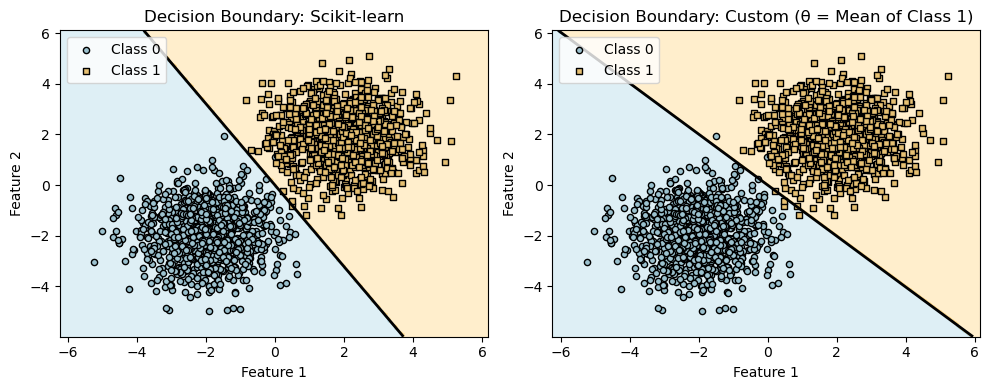

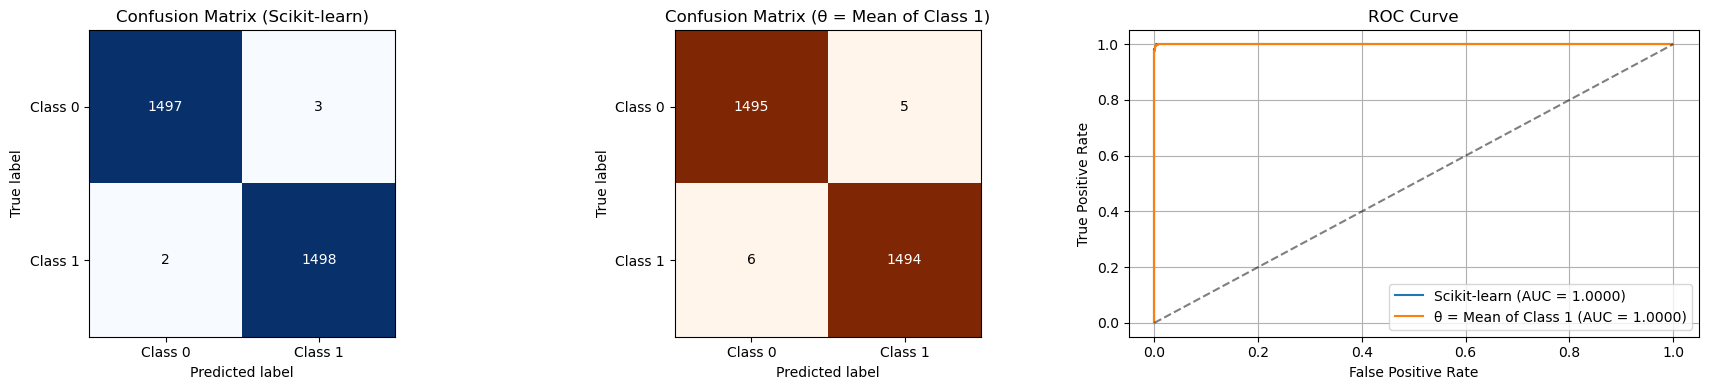


Metric                             Scikit-learn             θ = Mean of Class 1
-------------------------------------------------------------------------------------
Sensitivity (Recall)               0.9987                   0.9960
Specificity (TNR)                  0.9980                   0.9967
Precision (PPV)                    0.9980                   0.9967
Negative Predicted Value (NPV)     0.9987                   0.9960
Accuracy                           0.9983                   0.9963
F1 Score                           0.9983                   0.9963
AUC                                1.0000                   1.0000


In [11]:
# Define hyperparameters
n_samples = 1500
test_size = 0.3
seed = 42
mean0 = np.array([-2, -2])
mean1 = np.array([2, 2])

# Generate and split data
X, y = generate_data(n_samples, seed, mean0, mean1)
X_train, X_rest, y_train, y_rest = split_data(X, y, test_size, seed)

# Train scikit-learn logistic regression model
model_sklearn = train_model_sklearn(X_train, y_train)
y_pred_sklearn = model_sklearn.predict(X)
y_scores_sklearn = model_sklearn.predict_proba(X)[:, 1]

# Use mean-based classifier
y_pred_custom, theta_custom = mean_based_classifier(X, y)

# For "scores" from the mean-based classifier, we'll use the dot product between X and θ
# Assuming higher dot product => more likely to be class 1
y_scores_custom = X @ theta_custom

# Visualize decision boundaries
plot_decision_boundaries(X_train, y_train, model_sklearn, theta_custom)

# Compare models with AUC and ROC
compare_models(
    y_true=y,
    y_pred1=y_pred_sklearn,
    y_scores1=y_scores_sklearn,
    y_pred2=y_pred_custom,
    y_scores2=y_scores_custom,
    name1="Scikit-learn",
    name2="θ = Mean of Class 1"
)


---
### **1.4 Analysis**

#### **1.4.1 General Observations**

<div style="text-align: justify">

- Both models performed quite well in separating the two classes. This is evident from the visualizations, where the decision boundaries clearly distinguish most of the data points belonging to each class.

- As discussed earlier, the difficulty of the classification task depends on the position of the class means. When the means of the two distributions are closer together, the data points from each class overlap more, making it harder for a model to find a clear boundary. On the other hand, increasing the distance between the means leads to more distinct clusters, which simplifies the classification task.

- For this experiment, we chose class means at `[2, 2]` for class 1 and `[-2, -2]` for class 0. This configuration strikes a balance—it avoids perfectly separable data (which would be too easy) while still providing a reasonably challenging problem. It's worth noting, however, that due to the randomness in data generation, the actual sample means are not exactly at these points. Instead, they tend to converge toward those values as the number of samples increases. To support this convergence and reduce variability, we used a large number of data points (1500 per class).
</div>



#### **1.4.2 Results and Model Comparison**

<div style="display: flex; justify-content: center;">

<table>
  <tr>
    <th>Metric</th>
    <th>Scikit-learn</th>
    <th>θ = Mean of Class 1</th>
  </tr>
  <tr>
    <td>Sensitivity (Recall)</td>
    <td>0.9987</td>
    <td>0.9960</td>
  </tr>
  <tr>
    <td>Specificity (TNR)</td>
    <td>0.9980</td>
    <td>0.9967</td>
  </tr>
  <tr>
    <td>Precision (PPV)</td>
    <td>0.9980</td>
    <td>0.9967</td>
  </tr>
  <tr>
    <td>Negative Predicted Value</td>
    <td>0.9987</td>
    <td>0.9960</td>
  </tr>
  <tr>
    <td>Accuracy</td>
    <td>0.9983</td>
    <td>0.9963</td>
  </tr>
  <tr>
    <td>F1 Score</td>
    <td>0.9983</td>
    <td>0.9963</td>
  </tr>
</table>

</div>

<div style="text-align: justify">

Based on the confusion matrices and metrics, we can see that both models performed exceptionally well on this dataset. The scikit-learn logistic regression model achieved slightly better results, but the differences are very small:

- Sensitivity (Recall) is slightly higher for the scikit-learn model (0.9987 vs. 0.9960), indicating it missed fewer actual positives. In other words, it was slightly better at catching all the true class 1 examples, with only 2 false negatives compared to the mean-based model's 6.

- Specificity (True Negative Rate) follows the same trend (0.9980 vs. 0.9967), showing that the scikit-learn model was also marginally better at identifying true negatives and avoiding false alarms.

- Precision (Positive Predictive Value), which reflects how many of the predicted positives were actually correct, is again slightly higher for the scikit-learn model (0.9980 vs. 0.9967). This aligns with its lower number of false positives (3 vs. 5).

- Negative Predictive Value (NPV) shows the same pattern, with the scikit-learn model reaching 0.9987 versus the mean-based model's 0.9960, meaning its predicted negatives were slightly more trustworthy.

- Accuracy shows only a minor advantage for the scikit-learn model (0.9983 vs. 0.9963), with a margin of less than 0.2%. This reinforces that both models are strong, but the logistic regression edges out the mean-based method.

- F1 Score, which balances precision and recall, is also slightly higher for the scikit-learn model (0.9983 vs. 0.9963), confirming its superior performance in balancing both false positives and false negatives.

The ROC curves further support these findings. Both models yield curves close to the top-left corner, with AUC values near 1, confirming excellent classification ability. The scikit-learn model's slightly higher AUC aligns with the other metrics and reinforces its slightly more consistent performance across thresholds.

</div>


#### **1.4.3 Trade-offs and Use Cases**

<div style="text-align: justify">

The scikit-learn model is trained via gradient-based optimization, making it more flexible and accurate—especially in real-world scenarios where the data is noisy or the classes are not linearly separable. However, this comes at a computational cost, especially with larger datasets or in resource-limited environments. By contrast, the mean-based classifier requires no training or iterations, has minimal computational cost and is interpretable and straightforward to implement. 

By contrast, the strength of the mean-based approach lies in its computational efficiency and interpretability. It does not require any training process or optimization—θ is simply defined as the average position of the positive class in the feature space. This makes it particularly appealing in contexts where resources are limited or where simplicity is valued over precision. For instance, in embedded systems or real-time applications such as wearable sensors or IoT devices, where power and memory are constrained, a simple rule-based classifier could be preferred. In these cases, sacrificing a small amount of predictive accuracy may be an acceptable trade-off for gains in speed and efficiency. 

However, the limitations of this approach could become more evident if we move beyond the ideal conditions provided in this project. If the data is not Gaussian, or if it displays significant skewness or outliers, the mean of class 1 may no longer represent a meaningful direction for separation. This is especially true for complex patterns like ring-shaped distributions, where the true boundary is nonlinear and cannot be captured by a single vector. Furthermore, if the class sizes are imbalanced or the variances differ substantially, the average of the positive class might point in a direction that leads to frequent misclassifications. 

While the scikit-learn logistic regression model outperforms the mean-based classifier by a small margin in this experiment, that margin may become much more pronounced in the presence of noise, irrelevant features, or overlapping classes. Logistic regression has the advantage of learning an optimized boundary using the full distribution of both classes, not just the location of a single class. It also benefits from regularization and hyperparameter tuning, features that are crucial in real-world datasets where the underlying data structure is rarely as clean as in synthetic examples.

</div>



<div style="text-align: justify">

#### **1.4.4 Conclusion**

In conclusion, the mean-based classifier is not without merit—it performs well in constrained or highly controlled scenarios, and its simplicity can be a feature rather than a flaw in the right context. Nevertheless, it is not a general-purpose solution. For most practical applications, especially those involving complex, high-dimensional, or noisy data, more flexible and trainable models like logistic regression could be more appropriate.

</div>


<div class="alert alert-block alert-info">


</div>

## **2. Linear Classification: MNIST**

In this section, we tackle the classic handwritten digit classification problem using the digits dataset from the scikit-learn library. We begin with an exploratory analysis of the data, followed by the implementation of different classification approaches, including KNN, logistic regression, and multinomial classification. Finally, we compare the performance of each method to evaluate their effectiveness.

---

### **2.0 Necessary Libraries**

In [12]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

---
### **2.1 Digit Data Uploading**

For this section we will need the dataset of handwritten digits (0 through 9) commonly used for classification and machine learning practice. To upload it, we will use `load_digits`, from Scikit-learn.

In [13]:
# Load the MNIST-like digits dataset (8x8 images of digits 0–9)
digits = load_digits()
X = digits.data      # Features (64 pixels per image)
y = digits.target    # Target labels (digits 0–9)

---

### **2.2 Descriptive Analysis of the Uploaded Digit Data**

In this section, we will analyze the information contained in the dataset we just loaded. This step is essential in machine learning, as we can't build an effective model without first understanding the data. In our case, this involves examining the digit images, exploring the size and structure of the dataset, and identifying any potential challenges. A thorough understanding of the data is crucial for developing a reliable and accurate classification model.

### **2.2.1 Data Dimension**

We will begin by printing the dimension of our digit data and its corresponding targets. With this, we aim to understand how the images are being represented.  

- The shape of `X` indicates that there are 1,797 samples, and since each image is 8 × 8 pixels, flattening them results in a vector of 64 values—each representing a pixel.  
- The shape of `y` shows that it contains the labels (or classes) for each image, meaning that every sample is associated with a digit class ranging from 0 to 9.

In [14]:
print("X Dimension:", X.shape)
print("y Dimension:", y.shape)

X Dimension: (1797, 64)
y Dimension: (1797,)


### **2.2.2 Digit Plotting**

The following code will display 10 digit images from the dataset. This is because the zip() function pairs elements from the subplots and the dataset, and it stops when the shortest input is exhausted—in this case, the grid only has 10 subplot axes (2 rows × 5 columns). Therefore, the loop only takes the first 10 images and their corresponding labels from the dataset. These sample digits will help us in our analysis, as we will be able to see the general shape, in pixels, that each digit has.

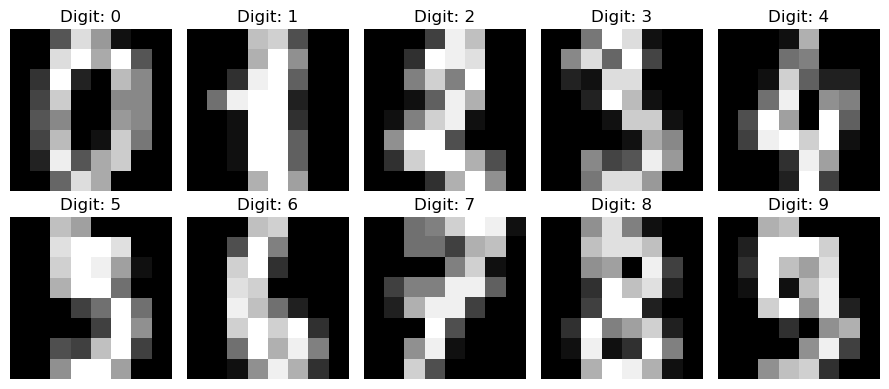

In [15]:
# Show one example of each digit
fig, axes = plt.subplots(2, 5, figsize=(9, 4))
for ax, img, label in zip(axes.ravel(), digits.images, digits.target):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Digit: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()


<div style="text-align: justify">
At first glance, we can identify some general characteristics of each digit in the image. The most recognizable is the zero, which typically has a clear round shape with a hole in the middle. Digits like 2, 3, and 8 appear quite similar, as they often feature rounded loops on both the top and bottom—this visual similarity could easily lead to misclassification. The digits 5 and 9 also share a resemblance, both forming a “C”-like shape; distinguishing a 9 often depends on the presence of a loop or hole near the top. Similarly, 1 and 7 can be confused, especially when the 7 lacks the horizontal stroke through the middle. It’s also noticeable that the digits are generally centered in the image, with black (low-value) pixels surrounding the strokes, which helps with visual separation but may still pose challenges for a classifier when digits are drawn with slightly different styles or intensities.

</div>

### **2.2.3 Pixel Value Statistics**

Next, we will display some key pixel statistics from the dataset X, specifically the minimum, maximum, mean, and standard deviation. This helps us better understand the range and distribution of pixel intensities.

In [16]:
# Dataset stats
print("Min:", np.min(X), ", Max:", np.max(X))
print("Mean:", np.mean(X), ", Std Dev:", np.std(X))

Min: 0.0 , Max: 16.0
Mean: 4.884164579855314 , Std Dev: 6.016787548672236



<div style="text-align: justify">

The minimum value = 0.0 and the maximum value = 16.0 align with the typical encoding in the scikit-learn digits dataset: each pixel can take values from 0 (black) to 16 (white). This confirms that the data is within the expected range and that some images contain pixels that are completely "off" (0) and others that are fully "on" (16).

The mean value of 4.88 indicates that, on average, pixel intensities tend to be close to 5 (on a scale from 0 to 16). This suggests that, considering all images and all pixels, the images are neither very dark (close to 0) nor very bright (close to 16) on average, but rather somewhere in the middle—slightly leaning toward the lower end, which makes sense due to the black background surrounding the digit strokes.

A standard deviation of approximately 6 shows a noticeable variation in pixel intensity. Since 6 is more than half of the mid-range value (0 to 16), we can expect significant differences between very light and very dark pixels in different regions of the images or among different digit classes. In practice, this means not all pixels have values close to the average; some are near 0 (blank areas around the digits), and others are closer to 16 (the core of the digit strokes).
This considerable variability (reflected in the standard deviation) is beneficial when training a recognition model, as it indicates the images capture a range of shapes and “ink levels” for each digit.

</div>

### **2.2.4 Digit Sample Distribution**

We will now examine the number of samples for each class (digit) to understand how the dataset is distributed. This is important because, for better model performance, we ideally want the classes to be balanced—each with a similar number of samples. An imbalanced dataset can lead to biased predictions and reduced accuracy for underrepresented classes

   Class  Frequency
0      0        178
1      1        182
2      2        177
3      3        183
4      4        181
5      5        182
6      6        181
7      7        179
8      8        174
9      9        180


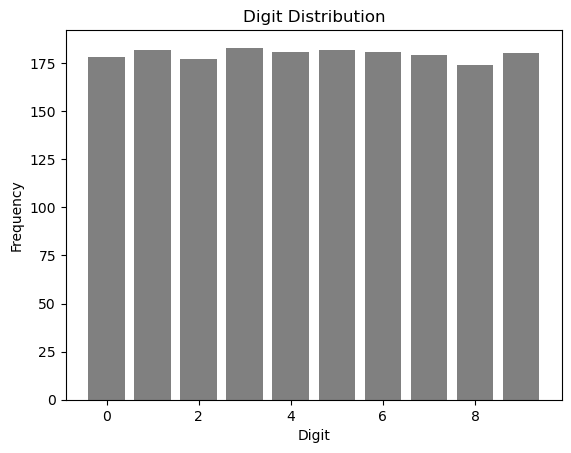

In [17]:
# Count how many samples of each digit
classes, counts = np.unique(y, return_counts=True)
df_counts = pd.DataFrame({"Class": classes, "Frequency": counts})
print(df_counts)

plt.bar(classes, counts, color='gray')
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.title("Digit Distribution")
plt.show()

<div style="text-align: justify">

Each digit (0–9) has approximately 174–183 samples, indicating a fairly balanced dataset. There are no classes with significantly fewer or more samples than the rest. The digit with the most samples (3) appears 183 times, while the one with the fewest samples (8) appears 174 times. The maximum difference (9 samples) is small relative to the total, which helps reduce the risk of serious bias when training classification models. Having such a balanced dataset also simplifies evaluation, as it makes it less likely for a model to "learn" only the majority classes at the expense of the minority ones.

### **2.2.5 2D & 3D PCA Projection**

To better understand the structure of the dataset, we will apply PCA (Principal Component Analysis) to reduce the dimensionality of the data and visualize it in 2D and 3D. Since each digit image in MNIST is originally represented in a high-dimensional space (784 features), projecting the data onto the first 2 or 3 principal components allows us to visualize the data's distribution and class separability in a simpler form. These 2D and 3D PCA projections help us observe how different digits cluster together and whether any overlap exists between classes, which can give us insights into how well a classifier might perform.

</div>

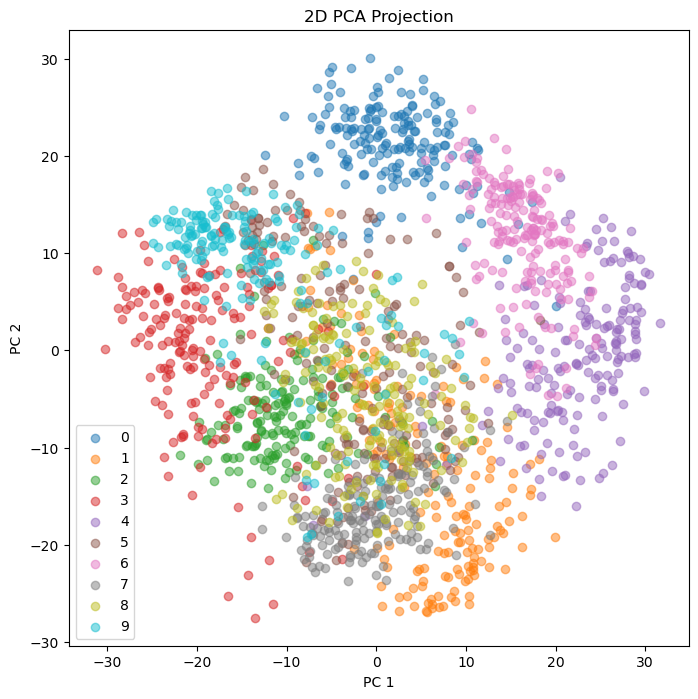

In [18]:
#2D Princial Component Analysis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,8))
for digit in range(10):
    idx = (y == digit)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=str(digit), alpha=0.5)
plt.legend()
plt.title("2D PCA Projection")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

Each color represents a different digit (0–9). We can observe that certain digits tend to cluster in relatively distinct regions of the 2D plane. For example, the digit "0" (in blue) often appears toward the bottom edge, while the digit "1" (in orange) is mostly concentrated at the top, and so on. This suggests that, in these two dimensions, some digits are reasonably well-separated. However, there is also some overlap between certain digits, which implies greater difficulty in distinguishing them.

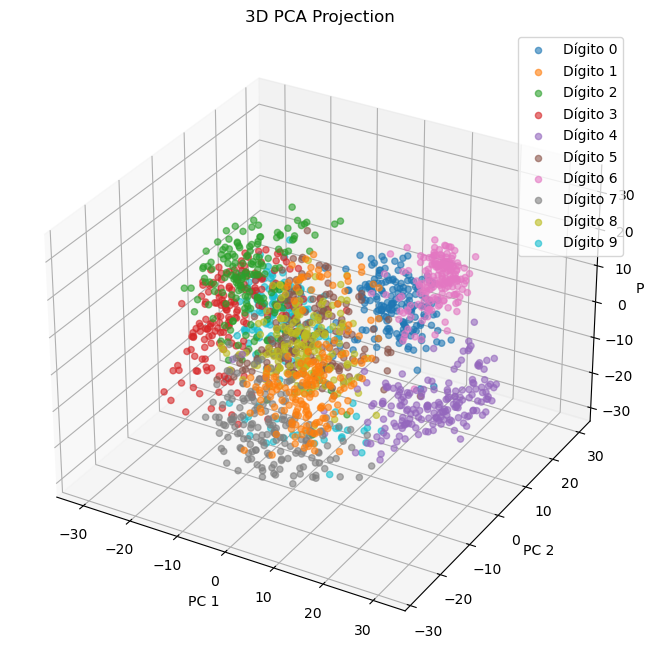

In [19]:
# 3D Princial Component Analysis
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)  

fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111, projection='3d')

for digit in np.unique(y):
    indices = (y == digit)
    ax.scatter(
        X_pca_3d[indices, 0],
        X_pca_3d[indices, 1],
        X_pca_3d[indices, 2],
        label=f"Dígito {digit}",
        alpha=0.6
    )

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("3D PCA Projection")
ax.legend()
plt.show()

<div style="text-align: justify">

We can also perform PCA in 3D, which allows for a slightly more accurate visualization of the data. In this case, we can observe that there is less overlap between digits compared to the 2D projection. However, it's important to keep in mind that reducing the original 64 pixel features down to only 2 or 3 dimensions inevitably results in some loss of information. This makes the projection less precise than working with the full feature space when recognizing digits.

From the PCA projection, we can confirm some of our earlier hypotheses about digit similarity and separability. For example, the digit 0 forms a very tight and well-separated cluster, suggesting that it will likely be easy for a model to identify. In contrast, digits like 7 and 1 appear very close together, indicating potential confusion between them. Similarly, the digit 8 shows significant overlap with both 3 and 9, which could make it harder to distinguish among those classes. We also observe that some digits are more dispersed in the PCA space. For instance, while 0 forms a compact cluster, the digit 3 appears more spread out, suggesting greater variability in how it is written.

---

### **2.3  Optimal K Selection for KNN**

In the following section,  we will implement K-Nearest Neighbors algorithm. However, we first need to define the number K. To do this we will implement a Cross-validated evaluation. Cross-validation is a technique in machine learning used to assess a model’s ability to generalize to unseen data. It works by splitting the dataset into several subsets, or "folds." In each iteration, one fold is set aside for validation while the model is trained on the remaining folds. This process is repeated so that each fold serves as the validation set once. In this case, we will use a 5-fold cross-validation, with accuracy as our performance metric.

</div>

K=1, Cross-Validated Accuracy=0.9644
K=2, Cross-Validated Accuracy=0.9672
K=3, Cross-Validated Accuracy=0.9666
K=4, Cross-Validated Accuracy=0.9638
K=5, Cross-Validated Accuracy=0.9627
K=6, Cross-Validated Accuracy=0.9594
K=7, Cross-Validated Accuracy=0.9599
K=8, Cross-Validated Accuracy=0.9583
K=9, Cross-Validated Accuracy=0.9566
K=10, Cross-Validated Accuracy=0.9549
K=11, Cross-Validated Accuracy=0.9555
K=12, Cross-Validated Accuracy=0.9561
K=13, Cross-Validated Accuracy=0.9555
K=14, Cross-Validated Accuracy=0.9561


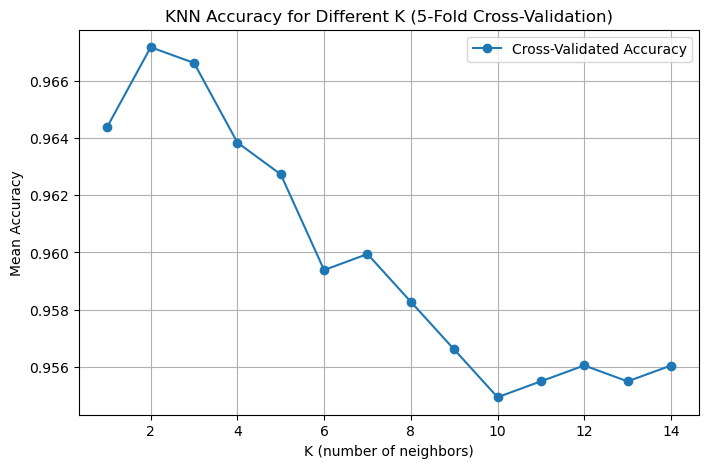


Best K (via CV): 2 with accuracy: 0.9672


In [20]:
def find_best_k(X, y, k_min=1, k_max=15, cv_folds=5, plot=True):
    """
    Perform cross-validation to find the best number of neighbors (K) for KNN.

    Parameters:
    - X: np.ndarray, feature matrix
    - y: np.ndarray, target labels
    - k_min: int, starting value of K (inclusive)
    - k_max: int, ending value of K (exclusive)
    - cv_folds: int, number of cross-validation folds
    - plot: bool, whether to display the accuracy plot

    Returns:
    - best_k: int, value of K with the highest mean accuracy
    - cv_accuracies: list of mean accuracies for each K
    """
    k_range = range(k_min, k_max)
    cv_accuracies = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv_folds, scoring='accuracy')
        mean_acc = np.mean(scores)
        cv_accuracies.append(mean_acc)
        print(f"K={k}, Cross-Validated Accuracy={mean_acc:.4f}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(k_range, cv_accuracies, marker='o', label='Cross-Validated Accuracy')
        plt.xlabel('K (number of neighbors)')
        plt.ylabel('Mean Accuracy')
        plt.title(f'KNN Accuracy for Different K ({cv_folds}-Fold Cross-Validation)')
        plt.grid(True)
        plt.legend()
        plt.show()

    best_k = k_range[np.argmax(cv_accuracies)]
    print(f"\nBest K (via CV): {best_k} with accuracy: {max(cv_accuracies):.4f}")
    
    return best_k, cv_accuracies

best_k, accuracies = find_best_k(X, y)

<div style="text-align: justify">

From the image, we observe that the highest accuracy is achieved when k = 2. However, it’s important to note that the optimal value of k can vary depending on the number of folds used in cross-validation. This means the selected value of k might not be universally optimal for our dataset. Nonetheless, our goal isn't to create a model that performs perfectly on a specific dataset, but rather one that generalizes well to unseen data. In this sense, cross-validation is a valuable technique, as it helps us mimic real-world conditions and avoid overfitting to a particular subset of data.

---

### **2.4 KNN Implementation**

Before implementing any of our models, we first define the training and test data. In this case, we will train with 70% of our data.

</div>

In [21]:
# Split  data for training
X_train_val, X_test_final, y_train_val, y_test_final = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Next, we define a function to evaluate our models. The function evaluate_model_performance will print a confusion matrix and a classification report.

In [22]:
def evaluate_model_performance(name, y_true, y_pred):
    """
    Print accuracy, classification report, and plot confusion matrix for a given model.

    Parameters:
    - name: str, name of the model (used for titles/labels)
    - y_true: ground truth labels
    - y_pred: predicted labels from the model

    Returns:
    - None (displays output)
    """
    acc = accuracy_score(y_true, y_pred)                    # Calculate overall accuracy
    print(f"\n{name} Accuracy: {acc:.4f}")
    
    print(f"\nClassification Report ({name}):")
    print(classification_report(y_true, y_pred))            # Print precision, recall, F1

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues')  # Plot confusion matrix
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

We now define a function to train our KNN model with the optimal value of K that we previously found through cross-validation.


K-Nearest Neighbors Accuracy: 0.9870

Classification Report (K-Nearest Neighbors):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.95      1.00      0.97        55
           2       1.00      1.00      1.00        53
           3       0.98      1.00      0.99        55
           4       0.98      1.00      0.99        54
           5       1.00      0.98      0.99        55
           6       1.00      1.00      1.00        54
           7       1.00      1.00      1.00        54
           8       0.98      0.92      0.95        52
           9       0.98      0.96      0.97        54

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



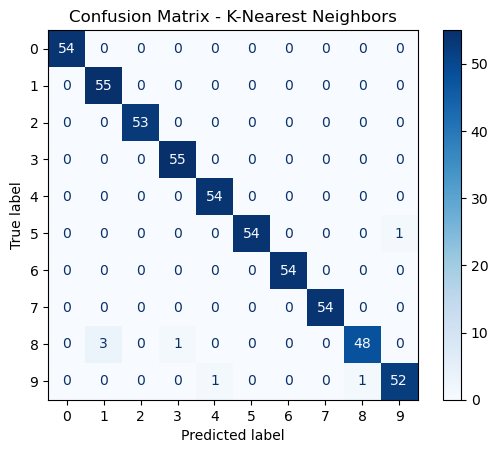

In [23]:
def train_knn(X_train, y_train, X_test, y_test, k):
    """
    Train a K-Nearest Neighbors classifier and evaluate its performance.

    Parameters:
    - X_train, y_train: training data and labels
    - X_test, y_test: test data and labels
    - k: number of neighbors to use in KNN

    Returns:
    - y_pred: predicted labels on the test set
    - model: trained KNN model
    """
    model = KNeighborsClassifier(n_neighbors=k)     # Create KNN model with specified K
    model.fit(X_train, y_train)                      # Fit model to training data
    y_pred = model.predict(X_test)                   # Predict test set labels
    evaluate_model_performance("K-Nearest Neighbors", y_test, y_pred)  # Print report & plot
    return y_pred, model

y_pred_knn, knn_model = train_knn(X_train_val, y_train_val, X_test_final, y_test_final, best_k)

---

### **2.4 Logistic Regression Implementation**

<div style="text-align: justify">

In this section, instead of using the K-Nearest Neighbors (KNN) algorithm, we implement logistic regression for multiclass classification. Since logistic regression is naturally a binary classifier, we use the One-vs-Rest (OvR) strategy to handle the 10-digit classification task (digits 0–9). This means we train one logistic regression model per class, where each model learns to distinguish one digit versus all the others. When making predictions, each model outputs a probability score, and the final predicted digit is the one with the highest probability across all models.

</div>


Logistic Regression (One-vs-Rest) Accuracy: 0.9574

Classification Report (Logistic Regression (One-vs-Rest)):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.92      0.89      0.91        55
           2       1.00      1.00      1.00        53
           3       0.98      0.98      0.98        55
           4       0.96      0.98      0.97        54
           5       1.00      0.96      0.98        55
           6       0.98      0.98      0.98        54
           7       0.96      0.98      0.97        54
           8       0.81      0.92      0.86        52
           9       0.96      0.89      0.92        54

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



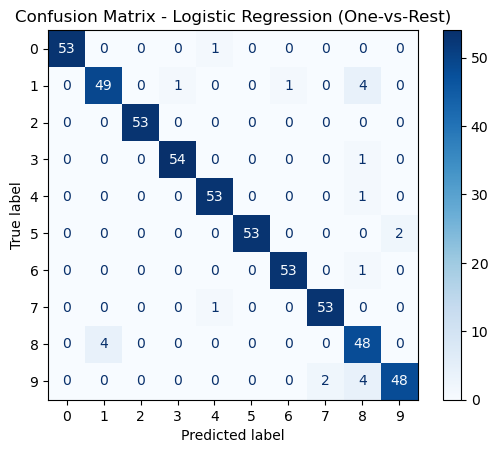

In [24]:
def train_logistic_ovr(X_train, y_train, X_test, y_test):
    """
    Train a One-vs-Rest logistic regression model and evaluate it.

    Parameters:
    - X_train, y_train: training data and labels
    - X_test, y_test: test data and labels

    Returns:
    - y_pred: predicted labels on the test set
    - model: trained OneVsRestClassifier model
    """
    model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))  # Create OvR model
    model.fit(X_train, y_train)                         # Train the model
    y_pred = model.predict(X_test)                      # Predict test set labels
    evaluate_model_performance("Logistic Regression (One-vs-Rest)", y_test, y_pred)

    # Verification step: check predictions match argmax of predict_proba
    probs = model.predict_proba(X_test)
    y_pred_proba = np.argmax(probs, axis=1)
    assert np.array_equal(y_pred, y_pred_proba), "Mismatch in predicted class vs argmax of proba"

    return y_pred, model

y_pred_ovr, ovr_model = train_logistic_ovr(X_train_val, y_train_val, X_test_final, y_test_final)


---

### **2.5 Logistic Regression Heat Maps**

Next, we use heat maps to visualize pixel-level information from the learned weights of our model.

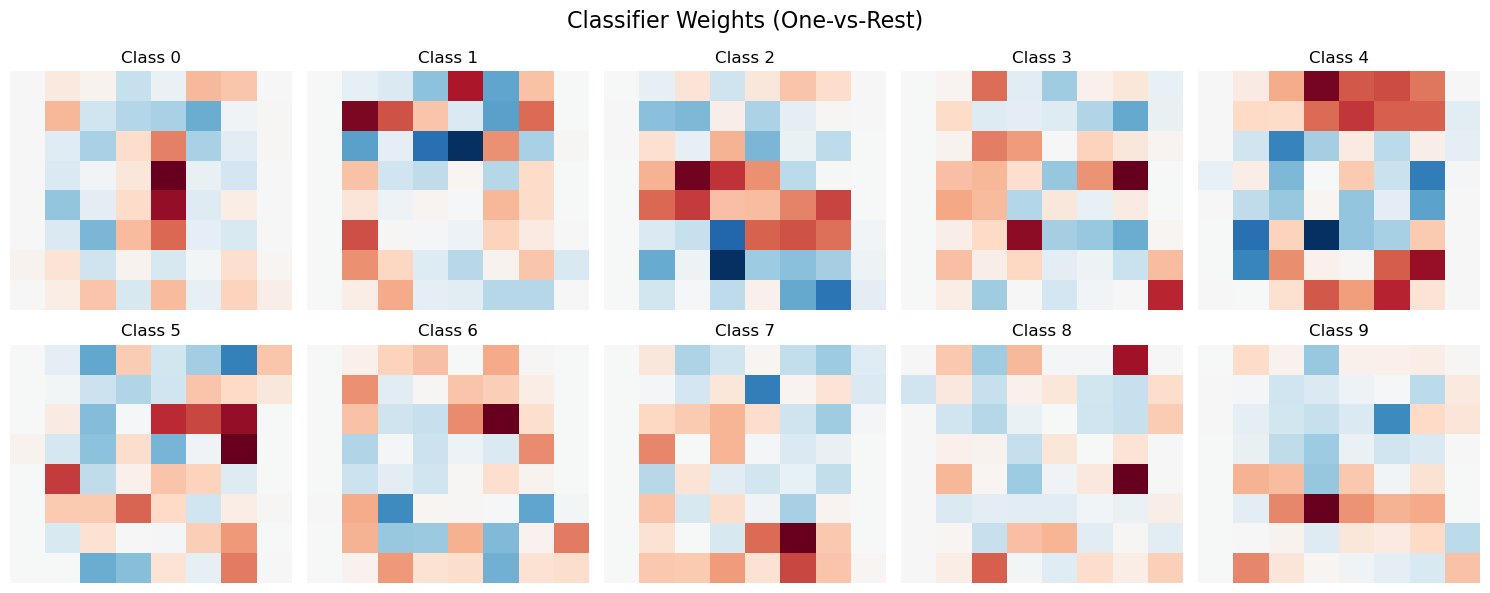

In [25]:
# Show how each classifier "sees" each digit
coefs = [est.coef_.reshape(8, 8) for est in ovr_model.estimators_]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    sns.heatmap(coefs[i], cmap='RdBu', center=0, ax=ax, cbar=False)
    ax.set_title(f'Class {i}')
    ax.axis('off')

fig.suptitle('Classifier Weights (One-vs-Rest)', fontsize=16)
plt.tight_layout()
plt.show()


From the coefficient heatmaps (or “weights”) of Logistic Regression for each digit (0 to 9), we can perform a qualitative analysis of which areas (pixels) are most relevant for classifying each number. Each heatmap corresponds to the weight matrix, which is a 64-length vector (one weight per pixel in an 8×8 image), reshaped into an 8×8 image format.

- **Positive values** (cooler tones): suggest that activating that pixel (i.e., having a high pixel value) supports the classification of that digit.
- **Negative values** (warmer tones): suggest that activating that pixel reduces the probability of that digit, favoring other competing classes.

| Digit | Heatmap Analysis |
|-------|------------------|
| **0** | A circular contour appears in cooler tones, supporting classification as 0. The center has warmer tones, matching the "hole" typical of the digit 0. |
| **1** | Though harder to distinguish, certain cool-tone pixels at the top (tip), vertical stroke (body), and base help form a rough horizontal representation of the digit. |
| **2** | The digit is visible at the top and bottom with a diagonal path connecting them. Some warm areas may interfere, but the main structure supports correct classification. |
| **3** | This is one of the clearest heatmaps. The digit shape is well-formed with cold tones following the correct pattern, aiding classification. |
| **4** | The digit 4 is mostly visible in cold tones, though some expected warm tones near the center are missing. Still, the structure is sufficient for recognition. |
| **5** | Characteristic elements like the top horizontal line and final curve are visible in cooler tones, helping distinguish this digit clearly. |
| **6** | The curved structure from top to bottom appears in cooler tones. The warm areas reflect the open lower-right side and central cavity, helping define the digit. |
| **7** | Very clearly defined. A strong cold-toned horizontal top line and descending diagonal form a clean representation of the 7. |
| **8** | The figure is well-shaped with cooler outer lines and warmer inner "holes" (top and bottom loops), accurately capturing the structure of 8. |
| **9** | The overall shape is present in cool tones. The central "hole" might lack expected warm contrast, but the curved trajectory is well represented for classification. |

---

### **2.6 Multinomial Classifier**

In this section, we implement multinomial logistic regression. Unlike the One-vs-Rest strategy, the multinomial approach models all classes jointly, taking into account the probabilities across all classes at once. This often leads to better performance when the classes are mutually exclusive, as in digit classification.


Logistic Regression (Multinomial) Accuracy: 0.9574

Classification Report (Logistic Regression (Multinomial)):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.93      0.91      0.92        55
           2       1.00      0.98      0.99        53
           3       0.98      0.98      0.98        55
           4       0.96      0.98      0.97        54
           5       0.96      0.96      0.96        55
           6       0.98      0.98      0.98        54
           7       0.96      0.98      0.97        54
           8       0.84      0.88      0.86        52
           9       0.96      0.93      0.94        54

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



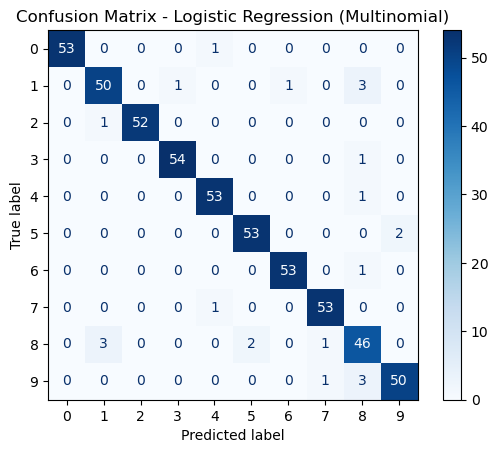

In [26]:
def train_logistic_multinomial(X_train, y_train, X_test, y_test):
    """
    Train a multinomial logistic regression model and evaluate it.

    Parameters:
    - X_train, y_train: training data and labels
    - X_test, y_test: test data and labels

    Returns:
    - y_pred: predicted labels on the test set
    - model: trained multinomial logistic regression model
    """
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1700)  # Create model
    model.fit(X_train, y_train)                         # Fit model to training data
    y_pred = model.predict(X_test)                      # Predict test set labels
    evaluate_model_performance("Logistic Regression (Multinomial)", y_test, y_pred)
    return y_pred, model

y_pred_multi, multi_model = train_logistic_multinomial(X_train_val, y_train_val, X_test_final, y_test_final)


---

### **2.7 Model Comparison**

Lastly, we compare the performance of both models by examining their confusion matrices side by side. To quantify their performance, we use accuracy as the primary metric, which is a common and appropriate choice for digit classification tasks.

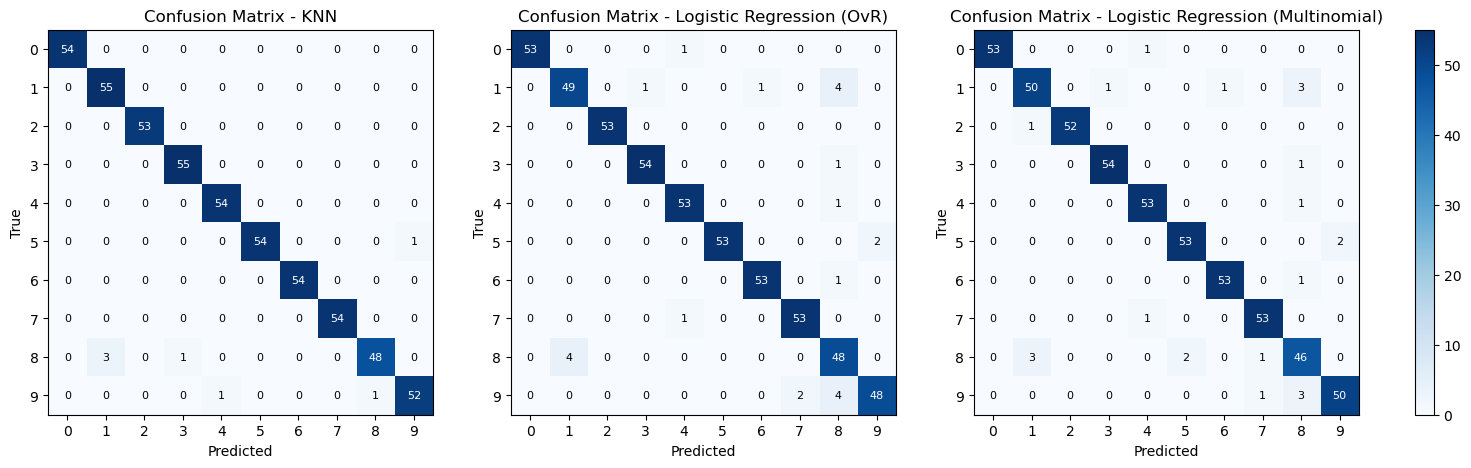

In [27]:
def plot_confusion_matrix_subplot(ax, y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title(title)
    tick_marks = np.arange(len(np.unique(y_true)))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(np.unique(y_true))
    ax.set_yticklabels(np.unique(y_true))
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if i == j else "black"  # White for diagonal, black elsewhere
            ax.text(j, i, cm[i, j],
                    ha="center", va="center", color=color, fontsize=8)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. KNN
plot_confusion_matrix_subplot(axes[0], y_test_final, y_pred_knn, title="Confusion Matrix - KNN")

# 2. Logistic Regression OvR
plot_confusion_matrix_subplot(axes[1], y_test_final, y_pred_ovr, title="Confusion Matrix - Logistic Regression (OvR)")

# 3. Logistic Regression Multinomial
plot_confusion_matrix_subplot(axes[2], y_test_final, y_pred_multi, title="Confusion Matrix - Logistic Regression (Multinomial)")

# Shared colorbar
fig.colorbar(axes[0].images[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

#### **2.7.1 Overall Comparison**

| Metric / Class | KNN                | Logistic Regression (OvR) | Logistic Regression (Multinomial) |
|----------------|--------------------|----------------------------|------------------------------------|
| **Accuracy**   | 0.9870             | 0.9574                     | 0.9574                             |
| **Macro Avg Precision** | 0.99               | 0.96                       | 0.96                               |
| **Macro Avg Recall**    | 0.99               | 0.96                       | 0.96                               |
| **Macro Avg F1-score**  | 0.99               | 0.96                       | 0.96                               |
| **Weighted Avg Precision** | 0.99           | 0.96                       | 0.96                               |
| **Weighted Avg Recall**    | 0.99           | 0.96                       | 0.96                               |
| **Weighted Avg F1-score**  | 0.99           | 0.96                       | 0.96                               |


#### **2.7.2 Per-Class Accuracy Comparison**

| Class | KNN (%)   | Logistic Regression (OvR) (%) | Logistic Regression (Multinomial) (%) |
|-------|-----------|-------------------------------|----------------------------------------|
| 0     | 100.00    | 98.15                         | 98.15                                  |
| 1     | 100.00    | 89.09                         | 90.91                                  |
| 2     | 100.00    | 100.00                        | 98.11                                  |
| 3     | 100.00    | 98.18                         | 98.18                                  |
| 4     | 100.00    | 98.15                         | 98.15                                  |
| 5     | 98.18     | 96.36                         | 96.36                                  |
| 6     | 100.00    | 98.15                         | 98.15                                  |
| 7     | 100.00    | 98.15                         | 98.15                                  |
| 8     | 92.31     | 92.31                         | 88.46                                  |
| 9     | 96.30     | 88.89                         | 92.59   


#### **2.7.2 Per-Class F1 Comparison**

| Class | KNN F1-score | OvR F1-score | Multinomial F1-score |
|-------|--------------|--------------|-----------------------|
| 0     | 1.00         | 0.99         | 0.99                  |
| 1     | 0.97         | 0.91         | 0.92                  |
| 2     | 1.00         | 1.00         | 0.99                  |
| 3     | 0.99         | 0.98         | 0.98                  |
| 4     | 0.99         | 0.97         | 0.97                  |
| 5     | 0.99         | 0.98         | 0.96                  |
| 6     | 1.00         | 0.98         | 0.98                  |
| 7     | 1.00         | 0.97         | 0.97                  |
| 8     | 0.95         | 0.86         | 0.86                  |
| 9     | 0.97         | 0.92         | 0.94                  |


<div style="text-align: justify">

In the overall comparison, the K-Nearest Neighbors (KNN) model clearly outperforms both versions of logistic regression. With an accuracy of 98.70%, compared to 95.74% for both One-vs-Rest and Multinomial Logistic Regression, KNN shows a stronger ability to correctly classify digits across the test set. This is further supported by its macro and weighted average precision, recall, and F1-scores, all consistently at 0.99. These metrics suggest that KNN not only maintains high performance across all classes but also handles potential class imbalances with remarkable effectiveness. On the other hand, both logistic regression models, while solid, display slightly lower and more varied results, each settling around 0.96 in all three averaged metrics.

Looking at the per-class accuracy, KNN again dominates, achieving 100% accuracy in 7 out of 10 digit classes. Its weakest performances are still quite strong, with 92.31% on digit 8 and 96.30% on digit 9. In contrast, the One-vs-Rest logistic regression model shows a noticeable dip for classes 1 and 9, where accuracy drops to 89.09% and 88.89% respectively. The Multinomial variant slightly improves upon this for class 9 (92.59%) but underperforms on class 8 (88.46%), which seems to be a generally difficult digit to classify. This trend is echoed in the per-class F1-scores, where KNN once again leads across the board, with near-perfect or perfect values in all classes except class 8 (0.95) and class 1 (0.97). Logistic regression models consistently show lower F1-scores in those same classes, with OvR scoring particularly low on class 8 (0.86) and class 1 (0.91).

Overall, KNN not only provides the highest overall accuracy but also demonstrates superior consistency across individual digit classes. The logistic regression models, while competent, appear more sensitive to specific digits—particularly those that are visually similar to others—resulting in reduced class-level performance. For a task like handwritten digit recognition where subtle visual cues matter, KNN’s instance-based, non-parametric approach seems to have the upper hand.

</div>

---
<div style="text-align: justify">

**1. What influence does the choice of different K values have on the KNN classifier?**

For small values of k, such as k = 1, the model tends to have low bias, meaning it can fit the training data very closely. However, this also leads to high variance, as the decision boundary can change significantly with slight modifications to the training set. In other words, adding, removing, or altering just a few training samples can cause the model to shift its classification criteria dramatically. While it may classify the training data very well, it is at higher risk of overfitting.

On the other hand, large k values increase the model's bias, making it more "smoothed out" and less sensitive to small fluctuations in the training data. This reduces variance, but at the cost of potentially missing finer patterns—especially in classes with fewer samples—leading to higher misclassification rates and a risk of underfitting.

</div>

---

<div style="text-align: justify">

**2. What are the differences between the KNN classifier and logistic regression? Does one perform better than the other? Why?**

The main difference between KNN and Logistic Regression lies in how they make classification decisions and the type of “learning” they perform:

K-Nearest Neighbors (KNN) is a **non-parametric** algorithm, meaning it doesn’t learn a set of weights or parameters during training. Instead, it simply stores all the training examples along with their class labels. To classify a new input, the algorithm calculates the distance (typically Euclidean, though other metrics can be used) between the new point and all training samples. It then selects the *K* closest points — the *K nearest neighbors* — and counts how many belong to each class. The new example is assigned the class that appears most frequently among those neighbors. This reflects the intuitive idea that “a point should be classified based on what it most resembles”: if a new sample is surrounded mostly by examples from a certain class, it likely belongs to that class.

In contrast, **Logistic Regression** is a **parametric** model. In the context of digit recognition, it learns a weight vector for each class, where each component of the vector represents the contribution of a specific pixel to the probability of that class. When a new image is given, the model computes the dot product between the input pixel values and the learned weights, then applies a logistic function to produce the probability that the input belongs to each class. This approach enables very fast predictions, even on large datasets, since it only requires a weighted sum of pixel values.

Whether one model performs better than the other depends on the specific problem and dataset. In this particular case, KNN outperformed logistic regression. This may be due to the fact that:

- **KNN**, by relying on distance, can model class boundaries more flexibly. Since digits are represented by 64 pixels, the "spatial" similarity between images is directly reflected in the proximity of their vectors. As a result, choosing the most similar neighbors helps capture the distinctive strokes and shapes of each digit.

- The **Digits dataset** is of moderate size (~180 samples per digit, ~1797 total). On larger-scale problems, logistic regression may perform better due to its parametric nature and faster prediction time. However, for small or medium-sized datasets, KNN isn't penalized much during prediction and can perform highly accurate neighbor searches.

- Additionally, **KNN doesn’t impose a fixed decision boundary**. Instead, it defines the boundary locally around each example, which can lead to more accurate classifications for complex or intricately structured data — especially in image-based tasks.

</div>

---

<div style="text-align: justify">

**3. Does the logistic regression classifier perform well? How is its performance evaluated? If performance is lacking, what could be done to improve it?**

The logistic regression classifier performs reasonably well, achieving an overall accuracy of 95.74% for both the One-vs-Rest and Multinomial strategies. This indicates that the model correctly classifies the majority of the handwritten digits and is effective in many scenarios. Its performance is evaluated using a combination of accuracy, **precision**, recall, and F1-score, both at a macro and weighted average level, as well as on a per-class basis. These metrics provide a comprehensive view of how well the model distinguishes between different digits and how balanced its predictions are across classes.

However, compared to the K-Nearest Neighbors classifier, logistic regression does show weaker performance, particularly on certain classes such as digits 1, 8, and 9, where both accuracy and F1-scores drop noticeably. These weaknesses suggest the model may struggle with digits that are more visually similar to others or that have higher intra-class variability.

To improve its performance, several strategies could be considered. First, feature engineering or applying dimensionality reduction techniques like PCA might help the model capture more relevant patterns in the data. Second, hyperparameter tuning, such as adjusting the regularization strength, could enhance the model’s generalization capabilities. Additionally, using more advanced classifiers might offer better results for complex datasets like MNIST, where logistic regression’s linear decision boundaries can be a limiting factor. Finally, data augmentation could help the model become more robust by exposing it to a wider variety of digit styles.

</div>

---

<div style="text-align: justify">

**4. When generating the heatmap of logistic regression weights for the different classifiers, what do you observe? Are there any patterns? Why or why not?**

The heatmap reveals that the model assigns a specific weight to each pixel, which helps it form a decision-making criterion based on pixel intensity. Particularly, the model uses these pixel intensities to learn class-specific features. In the heatmap:

- Regions where white pixels (high intensity) are concentrated tend to be colored with cooler tones (bluish).

- Regions with black pixels (low intensity) are often assigned warmer tones (reddish).

This visual pattern illustrates how the model focuses on the most distinctive features of each digit. The regions that define the digit’s shape contribute more to the classification task, and therefore receive higher weights. In other words, the model learns the most characteristic shapes associated with each digit and uses this information to distinguish between them.

</div>

---

<div style="text-align: justify">

**5. What conclusions can you draw from this project? Share your opinion on the classification methods and how they were applied.**

This digit classification project offers valuable insights into the strengths and limitations of different classification algorithms, particularly K-Nearest Neighbors (KNN) and Logistic Regression.

KNN demonstrated excellent performance on the MNIST subset, achieving an impressive accuracy of **98.70%**, clearly outperforming logistic regression. This result highlights how effective KNN can be for smaller datasets, especially when an appropriate value of *k* is selected to balance between bias and variance. Since KNN is a non-parametric method that memorizes training instances and classifies based on distance to neighbors, it makes intuitive sense that it performs well in a digit recognition task — especially when digits are often similar and only a few close examples are needed to make a correct prediction.

However, KNN’s simplicity comes with significant trade-offs. As the dataset grows, the algorithm becomes computationally expensive, requiring distance calculations against every training point during inference. Additionally, it lacks a generalizable model, making it less suitable for large-scale or real-time applications. In contrast, logistic regression, while slightly less accurate in this case, offers a **scalable and efficient solution**. As a parametric model, it learns generalized patterns from the data and typically improves with more diverse training samples. This makes it a strong candidate for large datasets or scenarios where prediction speed and scalability matter.

Beyond these observations, it's also interesting to reflect on how the **nature of the task influences model choice**. For example, in this project, it made sense for KNN to use a small *k*, since digits can vary greatly due to different handwriting styles — and just a few close examples might be enough to make an accurate decision. But in other contexts, like image processing involving colors or textures, a larger *k* could help smooth out noise and create better transitions.

One of the most fascinating parts of the project was exploring the heatmaps, which provided a visual insight into **what the models are "looking at"**. As humans, we often recognize patterns unconsciously — we're used to seeing them. But these algorithms can highlight features or structures we might overlook, uncovering **new patterns and relationships** that could inspire further exploration. It’s a reminder of how machine learning not only automates tasks but can also help us discover **new ways of interpreting familiar data**.

</div>

<div class="alert alert-block alert-info">


</div>

## **3. Linear Regression: Artificial Dataset**

---

### **3.0 Necessary Libraries**

In [28]:
#Import necessary libraries
import ipywidgets as wd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import seaborn as sb

---

### **3.1 Data Loading and Descriptive Analysis**
First, the dataset is loaded and the first few records are displayed in order to identify how the data is organized within the loaded file.

In [29]:
#Load the regression data
data = pd.read_csv('RegressionData.csv')
print("First rows of the DataSet")
display(data.head())

First rows of the DataSet


,X1,X2,y
0,53.766714,1.347397,0.594013
1,183.388501,-1.338226,0.505659
2,-225.884686,-0.800645,0.253316
3,86.217332,-1.343605,0.453381
4,31.876524,1.151258,1.720519


Then, we observe the following information about the data in the file:

- **count**: Number of data points.  
- **mean**: Average.  
- **std**: Standard deviation.  
- **min/max**: Minimum and maximum values of the dataset.  
- **25%/50%/75%**: Percentiles.

In [30]:
print("\n Statistical Summary")
display(data.describe())


 Statistical Summary


,X1,X2,y
count,1000.000000,1000.000000,1000.000000
mean,-3.263196,0.073797,0.996858
std,99.896532,1.997194,0.791569
min,-323.203780,-6.144331,-0.650879
25%,-71.263595,-1.240731,0.331548
50%,-3.043251,0.099402,0.947372
75%,61.056271,1.347746,1.649241
max,357.839694,7.139736,3.325075



Finally, with the help of correlation, it is possible to identify how well the variables fit a straight line.

In [31]:
print("\n Correlation Matrix")
display(data.corr())


 Correlation Matrix


,X1,X2,y
X1,1.000000,-0.009280,0.017148
X2,-0.009280,1.000000,-0.411762
y,0.017148,-0.411762,1.000000


To better understand this informaion, we plot the correlation matrix.

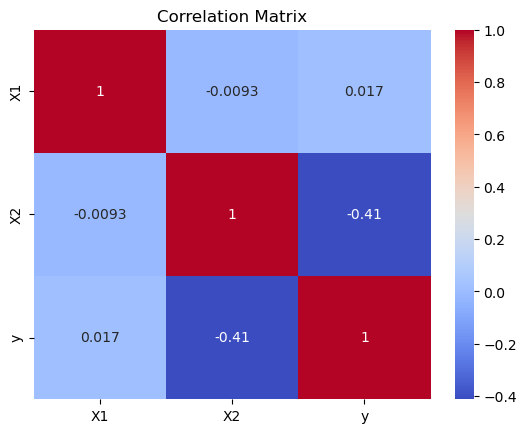

In [32]:
sb.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### **Observations**

- X1: The high standard deviation and wide range indicate that X1 is a highly dispersed variable, which may suggest the presence of outliers or a non-uniform distribution.

- X2: In contrast, X2 appears to be more stable, with values concentrated closer to its mean, suggesting a less variable or more consistent distribution.

- Correlation between X1 and Y: The low correlation suggests that there is little to no linear relationship between X1 and Y. This implies that a nonlinear transformation may be necessary to capture any hidden pattern.

- Correlation between X2 and Y: The moderate negative correlation indicates that, in general, as X2 increases, Y tends to decrease. However, the relationship is not particularly strong, meaning X2 alone may not be a highly predictive feature.

- Correlation between X1 and X2: The near-zero correlation between X1 and X2 suggests that these variables are linearly independent and do not influence each other directly.

---

### **3.2 Plot of Variable Behavior: X1, X2 vs Y**

To validate our assumptions about the data distribution, we will plot the variables to visually examine their behavior.

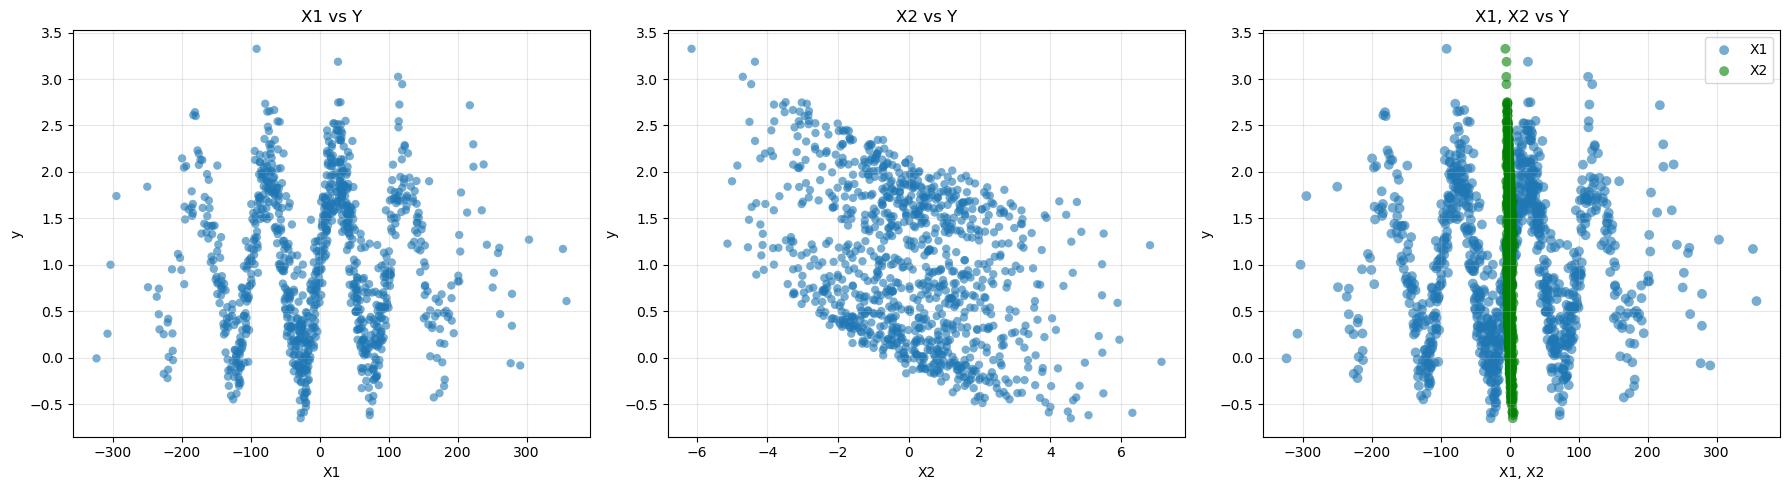

In [33]:
ig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# First plot: X1 vs Y
axs[0].scatter(data['X1'], data['y'], alpha=0.6, edgecolor='none')
axs[0].set_xlabel('X1')
axs[0].set_ylabel('y')
axs[0].set_title('X1 vs Y')
axs[0].grid(True, alpha=0.3)

# Second plot: X2 vs Y
axs[1].scatter(data['X2'], data['y'], alpha=0.6, edgecolor='none')
axs[1].set_xlabel('X2')
axs[1].set_ylabel('y')
axs[1].set_title('X2 vs Y')
axs[1].grid(True, alpha=0.3)

# Third plot: X1 and X2 vs Y
axs[2].scatter(data['X1'], data['y'], alpha=0.6, edgecolor='none', s=50, label='X1')
axs[2].scatter(data['X2'], data['y'], alpha=0.6, edgecolor='none', c='g', s=50, label='X2')
axs[2].set_title('X1, X2 vs Y')
axs[2].set_xlabel('X1, X2')
axs[2].set_ylabel('y')
axs[2].grid(True, alpha=0.3)
axs[2].legend()

plt.tight_layout()
plt.show()

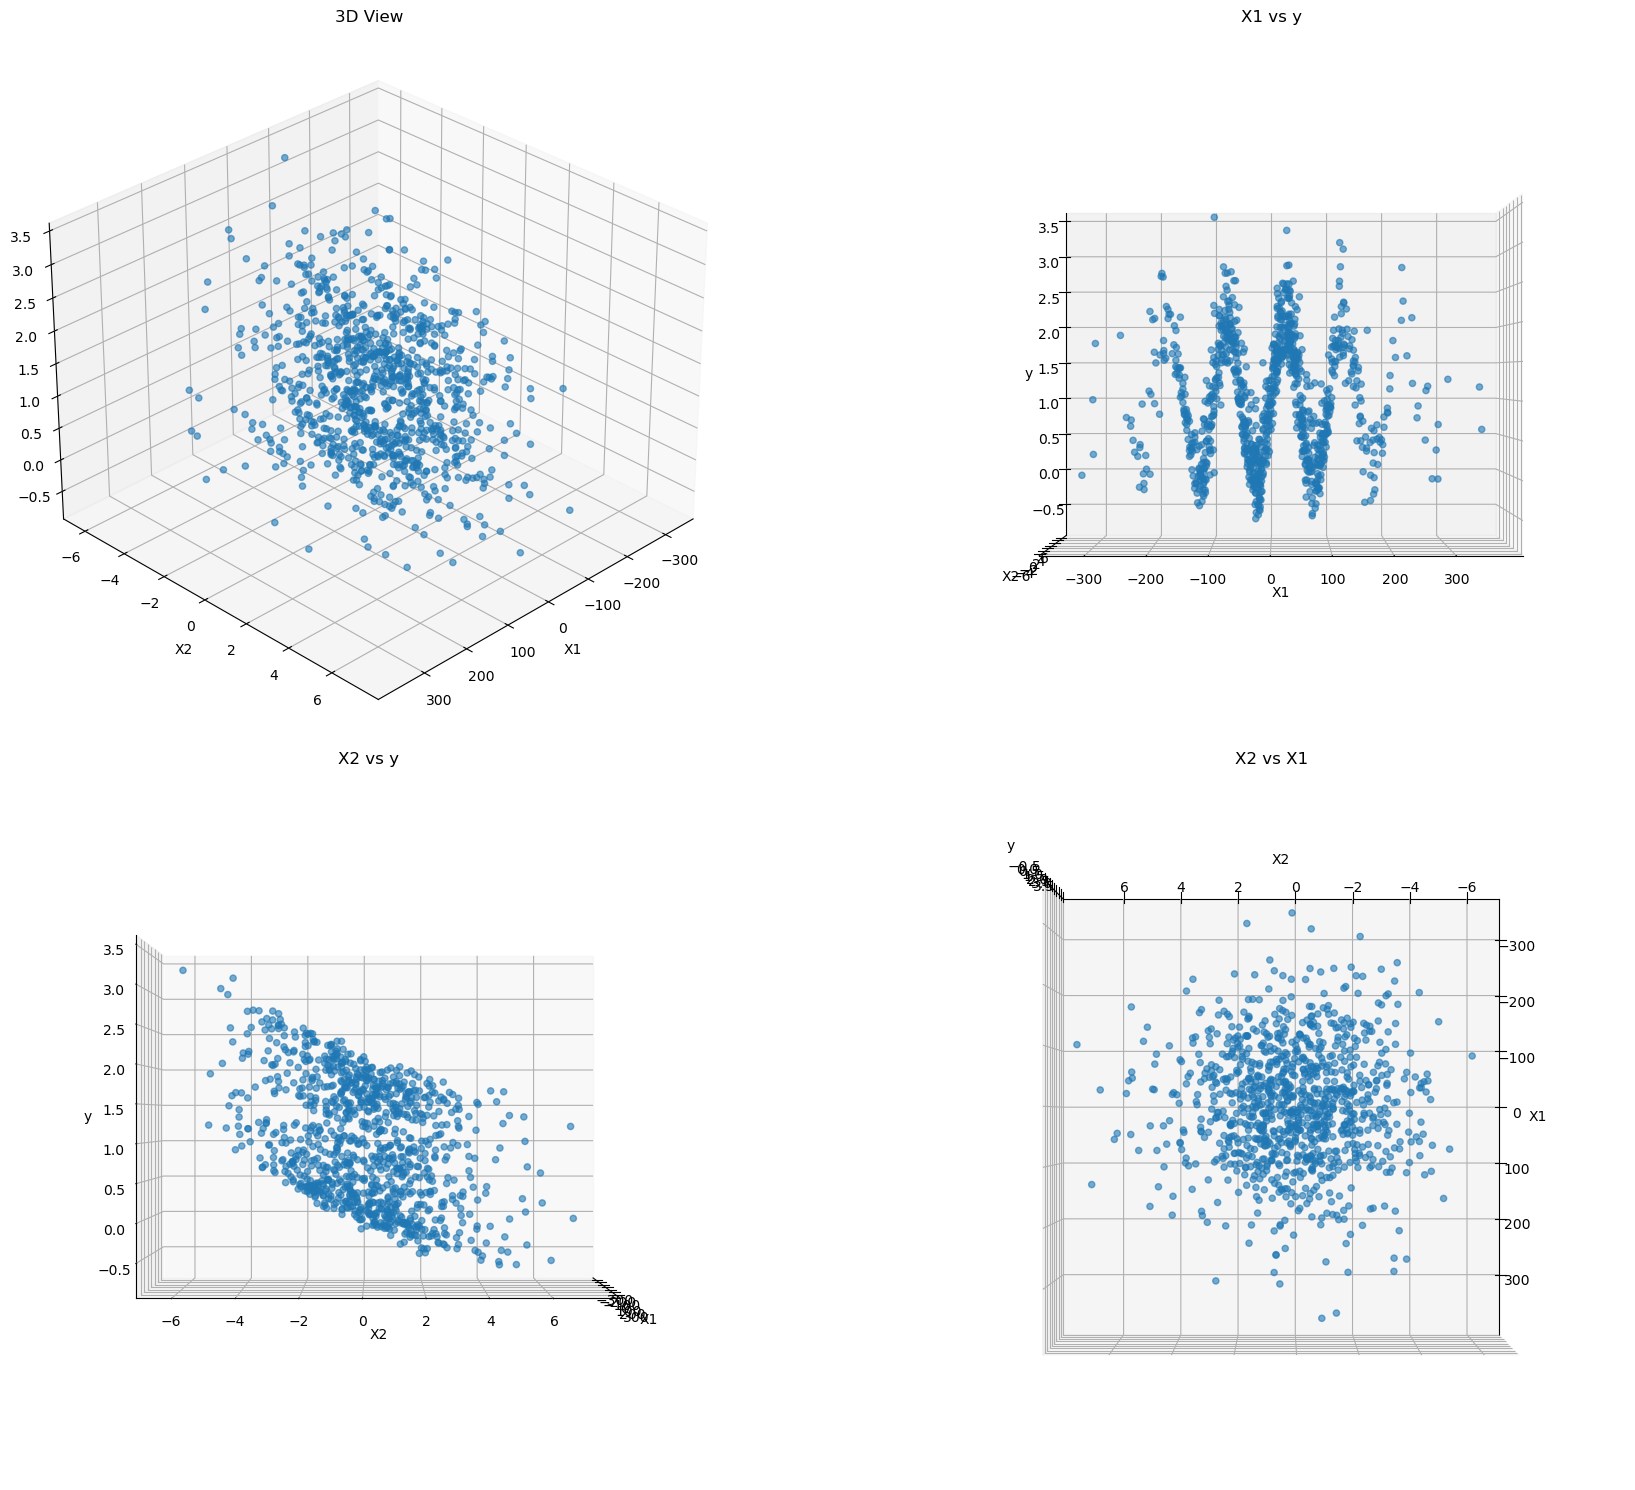

In [34]:
fig = plt.figure(figsize=(20, 15))
views = [
    {'elev': 30, 'azim': 45, 'title': '3D View'},
    {'elev': 0, 'azim': 270, 'title': 'X1 vs y'},
    {'elev': 0, 'azim': 0, 'title': 'X2 vs y'},
    {'elev': 270, 'azim': 180, 'title': 'X2 vs X1'}
]
for i, view in enumerate(views):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.scatter(data['X1'], data['X2'], data['y'], marker='o', alpha=0.6)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('y')
    ax.set_title(view['title'])
    ax.view_init(elev=view['elev'], azim=view['azim'])

plt.tight_layout()
plt.show()

### **3.2.1 Non-Linear Transformations**

Initially, we can observe that the distribution of X1 vs Y appears to follow a periodic pattern, with values rising and falling in a wave-like manner. In contrast, X2 vs Y shows a generally decreasing trend. Based on these observations, we can begin to speculate on potentially useful transformations: X1 seems to exhibit sinusoidal behavior with respect to Y, while X2 appears to follow a decaying exponential behavior.

#### **X1 Transformation: Sinusoidal**

To transform X1, we analyzed the apparent sine-like behavior of the data:

- The period of the wave appears to be around 100 units (as the pattern repeats every 100).
- The wave seems to be centered around 1, suggesting a vertical offset of 1.
- The amplitude of the oscillation is slightly less than 4, estimated to be around 3.5.

From this, we propose the following transformation for X1:

$$
y = 3.5 \cdot \sin\left(\frac{2\pi}{100} \cdot X_1\right) + 1
$$

#### **X2 Transformation: Exponential Decay**

From the scatter plot of X2 vs Y, we observed that Y decreases smoothly as X2 increases, which suggests an exponential decay trend. To model this behavior, we used the general exponential decay formula:

$$
y = A \cdot e^{-kX}
$$

Unlike the sinusoidal case with X1, it was more difficult to define precise values for A and k directly from the graph. Therefore, we followed an iterative approach, testing different parameter values based on the observed start and end points of the curve. After several adjustments, we determined that the most appropriate values were A = 1 and k = -0.07, leading to the following transformation:

$$
y = e^{-0.07 \cdot X2}
$$

With this formulation, we were able to apply a meaningful transformation to X2 that better captures its nonlinear relationship with Y.

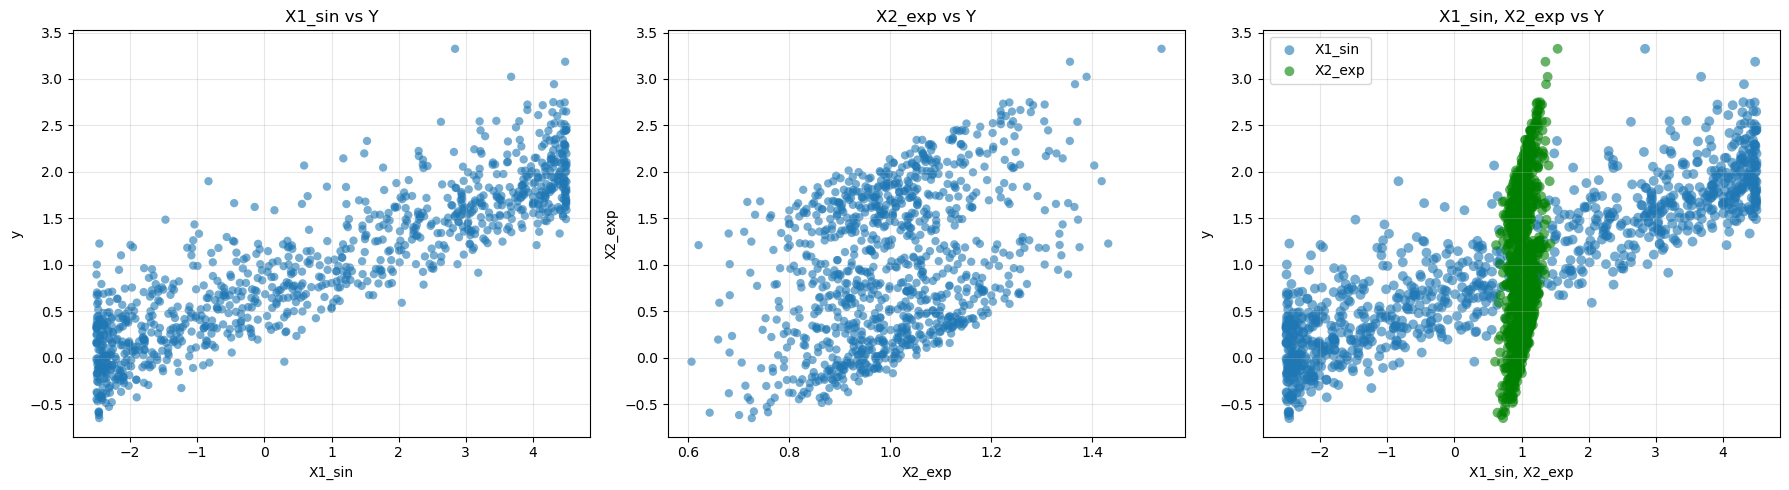

In [357]:
# Apply proposed transformations on X1 and X2
data['X1_sin'] = 3.5 * np.sin(2 * np.pi * data['X1'] / 100) + 1
data['X2_exp'] = np.exp(-0.07 * data['X2']) 

#Plot the modified variables to validate the transformations
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# First plot: X1_sin vs Y
axs[0].scatter(data['X1_sin'], data['y'], alpha=0.6, edgecolor='none')
axs[0].set_xlabel('X1_sin')
axs[0].set_ylabel('y')
axs[0].set_title('X1_sin vs Y')
axs[0].grid(True, alpha=0.3)

# Second plot: X2_exp vs Y
axs[1].scatter(data['X2_exp'], data['y'], alpha=0.6, edgecolor='none')
axs[1].set_xlabel('X2_exp')
axs[1].set_ylabel('X2_exp')
axs[1].set_title('X2_exp vs Y')
axs[1].grid(True, alpha=0.3)

# Third plot: X1 and X2 vs Y
axs[2].scatter(data['X1_sin'], data['y'], alpha=0.6, edgecolor='none', s=50, label='X1_sin')
axs[2].scatter(data['X2_exp'], data['y'], alpha=0.6, edgecolor='none', c='g', s=50, label='X2_exp')
axs[2].set_title('X1_sin, X2_exp vs Y')
axs[2].set_xlabel('X1_sin, X2_exp')
axs[2].set_ylabel('y')
axs[2].grid(True, alpha=0.3)
axs[2].legend()

plt.tight_layout()
plt.show()

After applying the transformations, the data seems to follow a much more linear trend. This will help improve the performance of the linear regression.

---

### **3.3 Linear Regression Algorithm Implementation**

First, the data from each column of the dataset is extracted, and a vector of ones is created to account for the bias term in matrix A. 

In [367]:
# Create a vector of ones 
ones = np.ones((len(data), 1))

# Extract each column from the dataset
X1 = data['X1_sin'].values
X2 = data['X2_exp'].values

Y = data['y'].values

After extracting the data, the independent and dependent variables are normalized to ensure they are on a comparable scale. This step is essential to prevent features with larger ranges from disproportionately influencing the learning process. Once normalized, the data is converted into NumPy arrays to enable efficient mathematical operations during training.

Next, the design matrix A is constructed by combining the independent variables with a column of ones to account for the bias term. In addition, we include nonlinear features, specifically X2 squared and the interaction term X1 times X2, to capture more complex relationships in the data. This decision was motivated by the correlation matrix, which revealed that X2 alone is not a strong predictor of the target variable.

Finally, the initial parameter values (θ) are randomly initialized to serve as a starting point for the optimization process.

In [368]:
# Normalize data
min_X1, max_X1 = X1.min(), X1.max()
min_X2, max_X2 = X2.min(), X2.max()

X1 = (X1 - min_X1) / (max_X1 - min_X1)
X2 = (X2 - min_X2) / (max_X2 - min_X2)


y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(data[['y']])

# Convert data to NumPy vectors
vector_X1 = X1.reshape(-1, 1)
vector_X2 = X2.reshape(-1, 1)

vector_Y = np.array(y_scaled)

num_data = len(vector_Y)

# Create matrix A
matrix_A = np.column_stack((X1, X2, X2*X2, X1*X2 ,ones))

# Initialize random thetas
random_thetas = np.random.uniform(-0.01, 0.01, size=(matrix_A.shape[1], 1))
initial_thetas = random_thetas.copy()

Next, we define the following functions to carry out key steps in the regression process:

- prediction_model: Computes predictions using the linear regression model in matrix form.

- compute_cost: Calculates the Mean Squared Error (MSE), quantifying how far the predictions deviate from the actual values.

- compute_gradient: Determines the gradient of the cost function with respect to the model parameters, indicating the direction in which the thetas should be updated to minimize error.

In [369]:
# Functions for model prediction, cost, and gradient
def prediction_model(matrix_A, initial_thetas):
    return matrix_A @ initial_thetas

def compute_cost(vector_Y, predictions, num_data):
    error = vector_Y - predictions
    return (1 / num_data) * np.sum(error ** 2)

def compute_gradient(matrix_A, vector_Y, num_data, predictions):
    return (1 / num_data) * (-2 * matrix_A.T @ (vector_Y - predictions))

Once the mathematical components of the model are defined, we proceed to implement the training process using the gradient descent algorithm, which iteratively updates the parameters θ in order to minimize the cost function.

In [390]:
# Initialize parameters
alpha = 0.1
iterations = 5000  
current_thetas = initial_thetas.copy()
cost_list = []
saved_thetas = [current_thetas]

# First prediction and gradient
predictions = prediction_model(matrix_A, current_thetas)
grad = compute_gradient(matrix_A, vector_Y, num_data, predictions)

# Gradient Descent loop
for i in range(iterations):  

    # Update parameters
    current_thetas = current_thetas - alpha * grad
    saved_thetas.append(current_thetas)
    
    # Compute predictions with updated thetas
    predictions = prediction_model(matrix_A, current_thetas)
    
    # Compute cost and gradient
    J = compute_cost(vector_Y, predictions, num_data)
    grad = compute_gradient(matrix_A, vector_Y, num_data, predictions)
    
    # Save current cost
    cost_list.append(J)

# Print final results
print('Final Cost (MSE):', J)
print('Final Parameters:\n', current_thetas)

Final Cost (MSE): 0.0006381909763890727
Final Parameters:
 [[ 0.49246064]
 [ 0.26210302]
 [ 0.32580951]
 [ 0.03455348]
 [-0.00537379]]


Since the cost value is close to zero, we can conclude that the model has effectively fit the normalized data. To further validate this result, we will plot the actual data alongside the model's predictions for visual comparison.

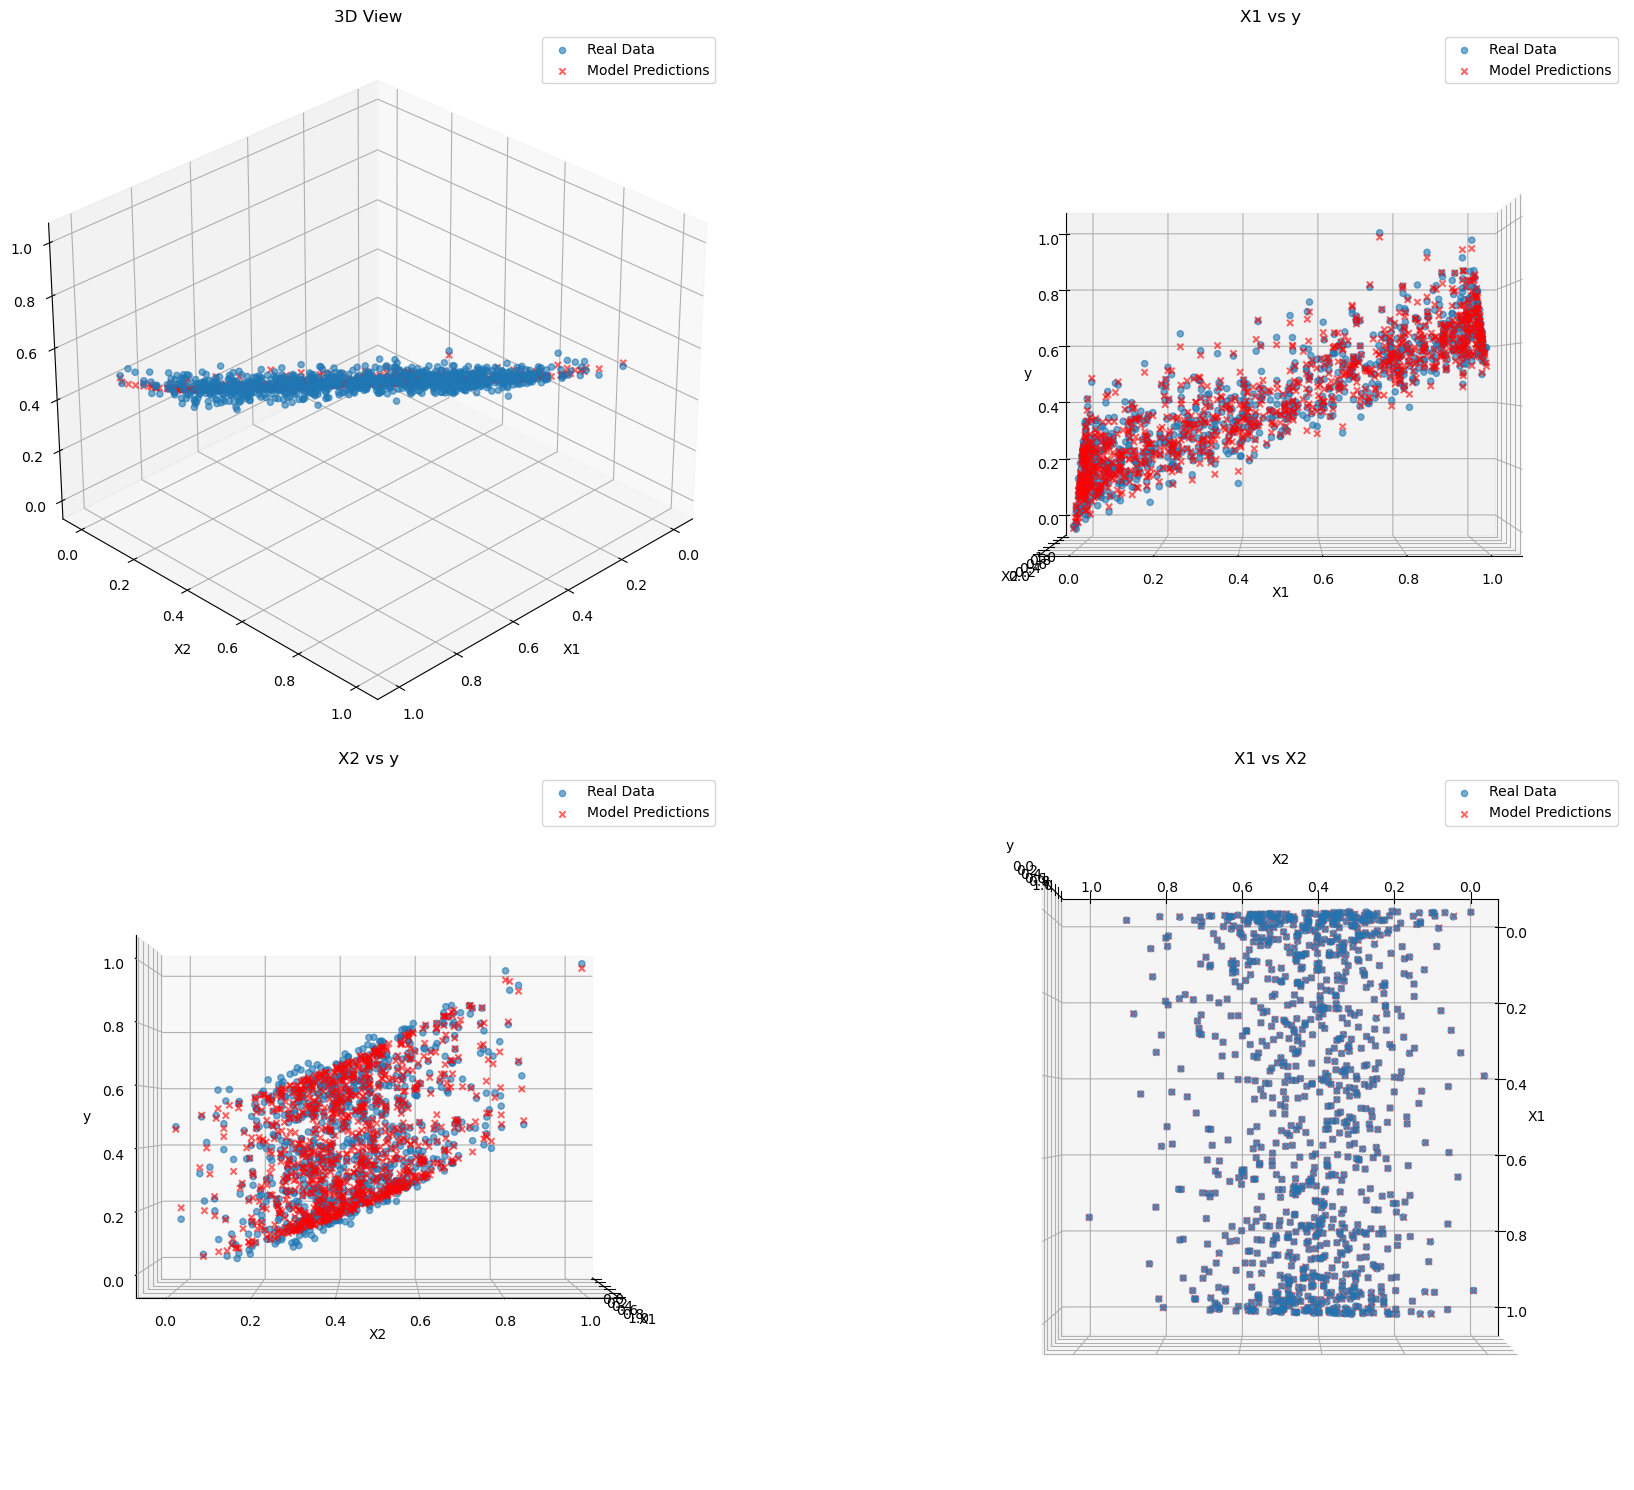

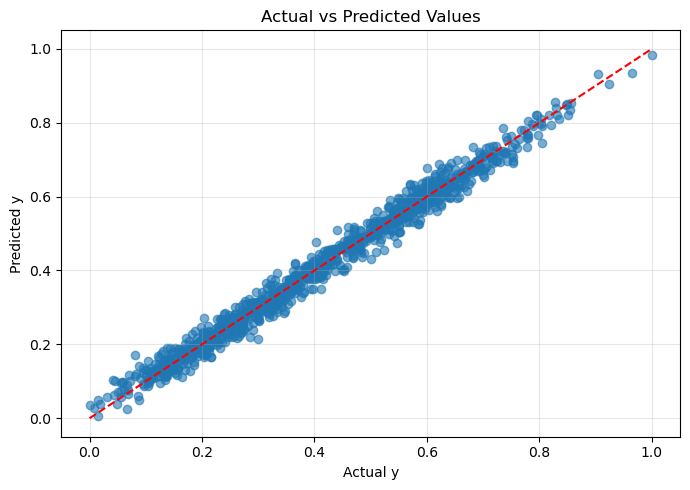

R² score: 0.9839


In [391]:
#Make predictions using the trained model
final_predictions = prediction_model(matrix_A, current_thetas)

# Prepare data for plotting 
xnew_1 = vector_X1
xnew_2 = vector_X2

# Define 3D views 
views = [
    {'elev': 30, 'azim': 45, 'title': '3D View'},
    {'elev': 0, 'azim': 270, 'title': 'X1 vs y'},
    {'elev': 0, 'azim': 0, 'title': 'X2 vs y'},
    {'elev': 270, 'azim': 180, 'title': 'X1 vs X2'}
]

# Create 3D plots 
fig = plt.figure(figsize=(20, 15))

for i, view in enumerate(views):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')

    # Real data
    ax.scatter(vector_X1, vector_X2, vector_Y, marker='o', alpha=0.6, label='Real Data')

    # Model predictions
    ax.scatter(xnew_1, xnew_2, final_predictions, c='r', marker='x', alpha=0.6, label='Model Predictions')

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('y')
    ax.set_title(view['title'])
    ax.view_init(elev=view['elev'], azim=view['azim'])
    ax.legend()

plt.tight_layout()
plt.show()

#  Actual vs Predicted plot 
plt.figure(figsize=(7, 5))
plt.scatter(vector_Y, final_predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Actual vs Predicted Values')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#  NEW: R² score 
r2 = r2_score(vector_Y, final_predictions)
print(f"R² score: {r2:.4f}")


Visually, the model appears to be very successful in predicting the values. The actual data points closely surround the predicted value line, indicating a strong fit. Additionally, the R² score is 0.9839, which is excellent — this means that 98.39% of the variance in the target variable is explained by the model. Such a high R² suggests that the model generalizes well and captures the underlying patterns in the data effectively.

Next, we plot the residuals, which are the differences between the actual values and the values predicted by our model.

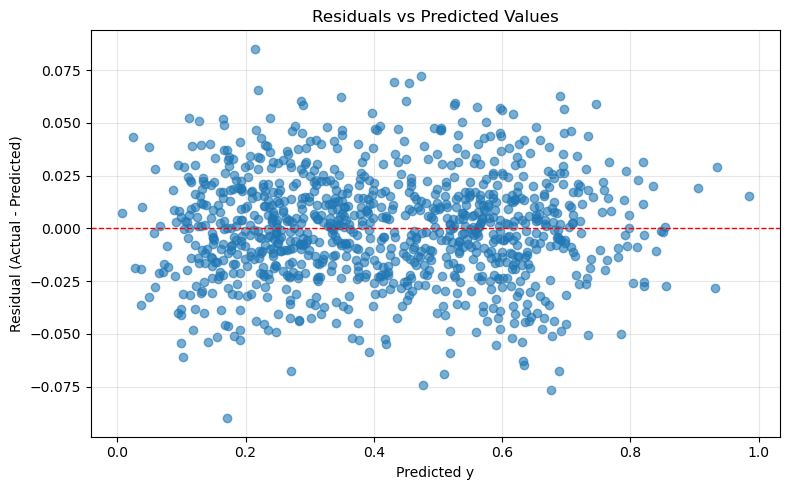

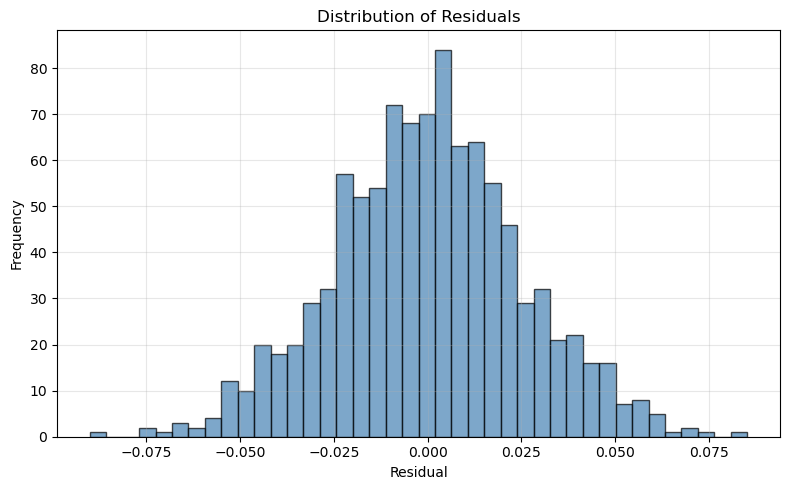

In [392]:
# Make predictions using the trained model 
final_predictions = prediction_model(matrix_A, current_thetas)

# Compute residuals
residuals = vector_Y.flatten() - final_predictions.flatten()

# Plot Residuals vs Predicted Values
plt.figure(figsize=(8, 5))
plt.scatter(final_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted y')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted Values')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Histogram of Residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=40, color='steelblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The residual plot shows that most residuals are centered around zero with no discernible trend, which suggests that the model fits the data reasonably well; this is further confirmed by the histogram of residuals, which indicates that these values remain between -0.1 and 0.1.

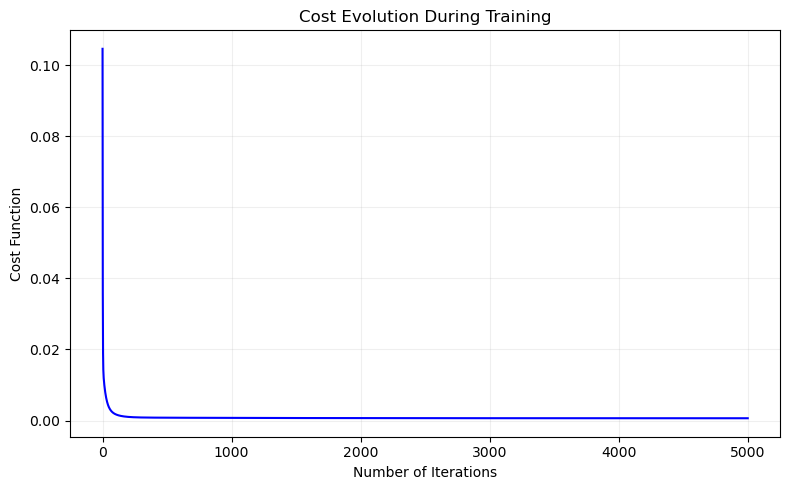

In [393]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(iterations), cost_list, color='blue')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost Function')
plt.grid(visible=True, alpha=0.2)
plt.title('Cost Evolution During Training')
plt.tight_layout()
plt.show()

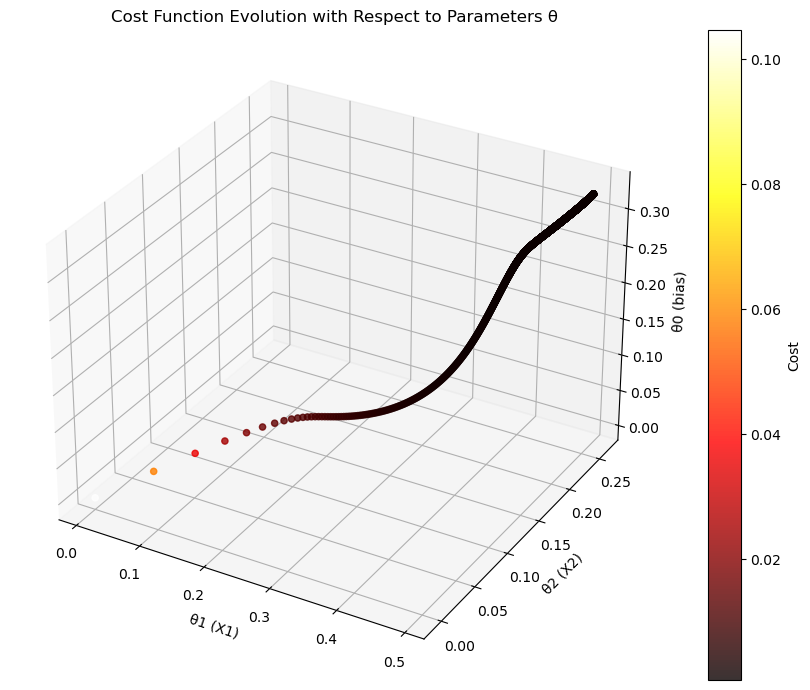

In [394]:
# 3D Plot of Theta Parameters Evolution with Cost

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_title("Cost Function Evolution with Respect to Parameters θ")
ax.set_xlabel("θ1 (X1)")
ax.set_ylabel("θ2 (X2)")
ax.set_zlabel("θ0 (bias)")

# Extract theta values
theta1_vals = [float(param[0][0]) for param in saved_thetas[:-1]]
theta2_vals = [float(param[1][0]) for param in saved_thetas[:-1]]
theta0_vals = [float(param[2][0]) for param in saved_thetas[:-1]]

# Create scatter plot with color representing cost
img = ax.scatter(theta1_vals, theta2_vals, theta0_vals,
                 c=cost_list, cmap=plt.hot(), alpha=0.8)

# Color bar for the cost values
fig.colorbar(img, label='Cost')

plt.tight_layout()
plt.show()

In [395]:
print("Initial Cost:", cost_list[0])
print("Final Cost:", cost_list[-1])

Initial Cost: 0.1046586412911049
Final Cost: 0.0006381909763890727


The final cost value after 5,000 iterations was 0.0006, a significant improvement from the initial cost of 0.10. This dramatic reduction confirms that the model successfully learned from the data.

Overall, we can conclude that the regression model was effective. The cost decreased steadily throughout training, as shown in the cost vs. iterations plot, and the model's predictions closely matched the actual values, as seen in the visualizations.

While the fit for X2 was slightly less accurate than for X1, this is likely due to the greater difficulty in identifying an optimal transformation for X2. In contrast, the periodic behavior of X1 was clearly visible and allowed for a well-defined sinusoidal transformation, which had a strong positive impact on model performance.

This analysis highlights a key takeaway: with the right feature transformations, even a basic regression model can be significantly improved.

Additionally, both the learning rate and the number of iterations play a critical role in training. Choosing an appropriate learning rate helped the model converge efficiently while avoiding divergence or stagnation. Furthermore, we normalized the data, which was essential — especially considering that the values of X2 were initially much smaller than those of X1. Normalization ensured that each variable contributed fairly during optimization, leading to better performance and faster convergence.


---

### **3.4 Analysis of Results**

#### 1. **How did you evaluate whether the regression was adequate?**

To evaluate the adequacy of the regression, we first monitored the mean squared error (MSE) throughout training. This is visualized in the cost vs. iterations plot, where a consistent decrease in cost indicates that the model is learning and improving its predictions. The final cost value, 0.0006, was significantly lower than the initial cost of 0.10, confirming that the model was successfully optimized over the training process.

In addition, we assessed model performance using the R² score, which was 0.9839. This indicates that approximately 98.39% of the variance in the target variable is explained by the model, a strong indicator of predictive accuracy.

To further support this, we plotted the actual vs. predicted values, where the points closely follow the diagonal reference line. This confirms that the model’s predictions align very well with the real data.

Finally, we examined the residuals plot, which displays the difference between the actual and predicted values. The residuals were mostly centered around zero and showed no obvious patterns, suggesting that the errors are randomly distributed and that the model is not systematically under- or overestimating. This randomness in residuals is a good sign, indicating that the model has captured the main structure of the data without major bias.

---

#### 2. **Did you perform any kind of nonlinear transformation on the input data? If so, what transformation did you apply and why?**

Yes, we applied nonlinear transformations to both input variables to better capture their relationships with the output variable y.

For x1, the plot of X1 vs. y clearly showed a periodic, wave-like pattern. Based on this, we applied a sinusoidal transformation with a specific amplitude, frequency, and vertical offset derived from visually analyzing the data's pattern. The function used was:

$$
y = 3.5 \cdot \sin\left(\frac{2\pi}{100} \cdot X_1\right) + 1
$$

For X2, we noticed a subtle decaying trend, which we modeled using an exponential decay function. To estimate the parameters of this function, we observed the values of X2 at key points (e.g., starting and ending values) and approximated the decay rate accordingly. The transformation used was:

$$
y = e^{-0.07 \cdot X_2}
$$

These transformations were derived initially through visual inspection, but it’s important to note that this is an iterative process. Initial parameter guesses can be refined to improve the model. The goal of these transformations is to make the relationship between inputs and outputs more linear, allowing the regression model to perform more effectively.

---

#### 3. **Do you consider the results obtained to be adequate, or could they be improved?**

Yes, the results obtained are adequate and demonstrate a strong model fit. The final cost was significantly reduced during training, and the R² score of 0.9839 indicates that the model explains the vast majority of the variance in the data. Additionally, the predicted values align closely with the actual data, as seen in the actual vs. predicted plot, and the residuals appear randomly distributed, which suggests there is no major bias in the model.

That said, there is always room for improvement. The fit for X2 is slightly less precise compared to X1, likely due to the weaker correlation and the challenge of selecting the most effective transformation. Testing regularization techniques or nonlinear models could be useful for generalization in more complex scenarios.

To conclude, while the current results are very good, they can still be refined through more advanced modeling techniques or deeper feature engineering.

---

#### 4. **What can you conclude at the end of this project? Share your opinion about linear regression methods and how they were applied in this project.**

The main conclusion of this project is that understanding your data is fundamental when applying linear regression. Human intuition plays a crucial role — we can often detect patterns like sinusoidal or exponential shapes just by visual inspection. If the origin of the data is known (e.g., physical systems, price fluctuations), even more insights can be gained, such as identifying meaningful outliers or expected behavior.

From a technical perspective, linear regression is a powerful tool, but it requires the data to be properly transformed and scaled. In this project, we used Gradient descent to train the model instead of the analytical solution. This allowed us to iteratively minimize the cost function, and we saw a clear drop in error after a sufficient number of iterations. This success was made possible by choosing a good learning rate, a large enough number of iterations, and most importantly, normalizing the data.

Before normalization, convergence was slow due to the different scales of X1 and X2 — X2 had much smaller values, which affected the learning process. Once we scaled both features appropriately, training improved significantly.

In summary, the key to implementing linear regression effectively is to:
1. Understand and visualize the data
2. Apply meaningful transformations to linearize the relationships
3. Normalize features to ensure balanced learning
4. Choose hyperparameters like learning rate and iterations carefully